# 0. Marking.

**_IMPORTANT_**: Save a copy of this notebook into your Drive before you start.

- Please attempt all the questions marked for your group (Part II ✅ | Part III/MPhil ✅).
- Continue to part 2 after you are done with this one.

Please submit a zip file, containing both parts, consiting of of:

1. A text file with a publicly visible link to your notebooks in Google Colab or GitHub.
2. A downloaded copy (ipynb) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report: we will not be re-executing the code you used to produce the answers unless required.

If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.


## Imports


In [1]:
import sys
sys.executable

'/Users/macbook/Desktop/L361/L361-Federated-Learning/.conda/bin/python'

In [2]:
# The simulation component of flower uses RAY under the hood.
# `pip` could produce some errors. Nothing to worry about.
# The execution has been verified; it is working anyway.
! pip install --quiet --upgrade "pip"
! pip uninstall tensorflow --y
! pip install tensorflow==2.15.0
! pip install git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching \
    ray=="2.6.3" torch=="2.2.1" torchvision=="0.17.1"  tqdm=="4.67.1" \
    torchsummary=="1.5.1" tensorflow-privacy matplotlib=="3.8.2"

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
  Using cached tensorflow-2.15.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached tensorflow_macos-2.15.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached google_auth-2.38.0-py2.py3-none-any.whl.metadata (4.8 kB)
  Using cached cachetools-5.5.1-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9-py3-none-any.whl.metadata (4.2 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 20.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/

In [3]:
# Imports
import random
from collections.abc import Callable
from copy import deepcopy
from pathlib import Path
from typing import Any
from logging import INFO


import flwr as fl
import numpy as np

import pandas as pd
import torch
from torch import nn
from flwr.common import (
    log,
    MetricsAggregationFn,
)
from flwr.client import Client
from flwr.common.parameter import ndarrays_to_parameters, parameters_to_ndarrays
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig, History
from flwr.server.server_returns_parameters import ReturnParametersServer as Server
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from torch.nn import Module
from torch.utils.data import DataLoader
from enum import IntEnum
from datetime import datetime, timezone
import json

import math


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

PathType = Path | str | None

### Paths


In [4]:
home_dir = Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

### Useful Python functions


In [5]:
def convert(o: Any) -> int | float:
    """Convert input object to Python numerical if numpy."""
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.int32 | np.int64):
        return int(o)
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.float32 | np.float64):
        return float(o)
    raise TypeError


def save_history(hist: History, name: str) -> None:
    """Save history from simulation to file."""
    time = int(datetime.now(timezone.utc).timestamp())
    path = home_dir / "histories"
    path.mkdir(exist_ok=True)
    path = path / f"hist_{time}_{name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)


def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
    server: Server | None = None,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap simulation to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
        server=server,
    )
    save_history(hist, name)
    return parameter_list, hist

### Dataset


In [6]:
# Decompress dataset
if not dataset_dir.exists():
    !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
    log(INFO, f"Dataset extracted in {dataset_dir}")

In [7]:
from common.client import FlowerClient, get_flower_client_generator
from common.client_manager import CustomClientManager
from common.strategy import DeterministicSampleFedAvg as FedAvgM
from common.client_utils import (
    get_network_generator_cnn,
    get_model_parameters,
    aggregate_weighted_average,
    get_federated_evaluation_function,
    get_default_test_config,
    get_default_train_config,
    get_device,
    DPAdaptiveClipFlagError,
    DPClientNormBitError,
)
from itertools import starmap

# 1. Introduction.


Welcome to the fourth lab session in our FL course. Having explored standard FL, data heterogeneity and device heterogeneity, we now focus on one of FL's main selling points: privacy.

The two methods for achieving privacy we will explore are client-level [**Differential Privacy**](https://ieeexplore.ieee.org/abstract/document/9069945) and [**Secure Aggregation**](https://research.google/pubs/pub45808/). Intuitively, the **first** provides statistical guarantees on how distinguishable a single client's pseudo-gradient is compared to the aggregated pseudo-gradient without its contribution.

<!-- a probabilistic bound on how distinct the final model trained using the data of a given client would be from the same model trained without data from that client (thus if a client contains all samples from a given class, it should be difficult for the model to predict that class as it would have to violate DP).  -->

In an ideal privacy scenario, we would prefer it if two global models trained with or without the data of a given client were indistinguishable.
The **second** is a cryptography-based solution that effectively erases the ability to identify a client during aggregation by encrypting all client model updates to produce the correct aggregate when summed.

As these topics are pretty in-depth, we will not cover them to the same level of detail as previous labs concerning theoretical subjects (such as data heterogeneity in lab 2). This lab will be primarily experimental to test the algorithms put into practice. We will, however, begin with a light introduction. Suppose you are interested in learning more about the subject. In that case, we may recommend the following papers [Deep Learning with Differential Privacy](https://arxiv.org/pdf/1607.00133.pdf) \[1], [Learning Differentially Private Recurrent Language Models](https://arxiv.org/pdf/1710.06963.pdf) \[2] and [Differentially private learning with adaptive clipping](https://arxiv.org/abs/1905.03871) \[3] on the DP front. For secure aggregation consider the original paper [Practical Secure Aggregation for Federated Learning on User-Held Data](https://arxiv.org/pdf/1611.04482.pdf) \[4] and the improved [LightSecAgg](https://arxiv.org/abs/2109.14236) \[5].

Secure aggregation does not harm the model's accuracy and demands only increased communication. Any samples involved in training may still be reconstructed in an attack; however, knowing who contributed the samples will not be possible. Thus, while the implementation is complex, its behaviour is predictable and shall be reserved for the end of the notebook as we are only concerned with measuring communication costs and answering conceptual questions. As such, let us dive into Differential Privacy after the following well-known imports.

> **Important** The entire notebook has been tested in a GPU-enabled Google Colab environment, which runs at around 6 minutes per FL experiment. All experiments require you to vary at most one parameter at a time, so please use a for loop to generate a list of histories rather than trying to manage multiple cells---most experiments rely on one run we create for demonstration purposes to cover one of the desire parameter values. We have purposefully reduced the size of the federated test set significantly and have also reduced the overall number of clients used during FL experimentation. If you are more constrained in your resources (e.g., you have run out of Google accounts that can get a GPU or you get an error peculiar to your exact colab machine), let us know either on Slack or in your submission, and we will either help you set up the code locally, potentially provide you with history objects, or offer take this into account during marking.

Citations:

1.  Abadi, Martin, et al. "Deep learning with differential privacy." Proceedings of the 2016 ACM SIGSAC conference on computer and communications security. 2016.
2.  McMahan, H. Brendan, et al. "Learning differentially private recurrent language models." arXiv preprint arXiv:1710.06963 (2017).
3.  Thakkar, Om, Galen Andrew, and H. Brendan McMahan. "Differentially private learning with adaptive clipping." arXiv e-prints (2019): arXiv-1905.
4.  Bonawitz, Keith, et al. "Practical secure aggregation for federated learning on user-held data." arXiv preprint arXiv:1611.04482 (2016).
5.  So, Jinhyun, et al. "Lightsecagg: a lightweight and versatile design for secure aggregation in federated learning." Proceedings of Machine Learning and Systems 4 (2022): 694-720.


# 2.Deep Learning With Differential Privacy


Before diving into a definition of Differential Privacy adapted to an FL context, we shall begin with the first version of DP applied to Deep Learning based on the aforementioned paper.

The authors of the original extension of _DP to Deep Learning_ justify the need for such a privacy mechanism based on the possibility that an attacker may reconstruct specific samples from the data perfectly in a sensitive context, such as facial recognition, while only having **black-box** access to the trained model. However, their algorithm for DP protects against even adversaries with full knowledge of the training procedure, access to the parameters and potential control over parts of the dataset.

Their **definition** of DP is as follows: a randomised mechanism $M: D ⟶ R$ (a neural network training procedure, in our case) satisfies $(ϵ,δ)$-differential privacy for any $S⊆R$ (a subset of outputs in the range $R$) if $Pr[M(d) \in S] \leq e^{\epsilon} Pr[M(d') \in S] + \delta$ holds, where $d∈D$ and $d'∈D$ are adjacent sets (datasets) of the same domain $D$ (set of all the possible datasets), i.e., they differ by only one record (a training sample, in our case). We can **interpret** this as stating that the probability of getting a particular output from our model when not including a specific sample should be close to the probability of getting the same output had we not included the sample. Specifically, when $\epsilon=0$, the two probabilities are equal, and it is impossible to find out if that sample was included in the training set. The bigger $\epsilon$ is the lower protection is. The probability that the model produces different outputs when trained on adjacent datasets increases exponentially with $\epsilon$.

> Importantly, the original definition of DP and the one you may have encountered before only contained the exponential term _without the_ $\delta$; however, this resulted in _very strong requirements_ for not breaking privacy. This new form, $(\epsilon, \delta)$ privacy relaxed the requirement. Informally, it can be interpreted as allowing privacy at a given $\epsilon$ level to be broken with _probability_ $1-\delta$. We do not have the scale of experimentation necessary to consider both in this lab, as such we will focus on $\epsilon$ values at the detriment of analysing changes in $\delta$. For the experiments in this lab, you can consider DP to be defined entirely in terms of ϵ. Formally, the transition to $(\epsilon, \delta)$ delta was necessary to move from an inefficient noise generation mechanism to Gaussian noise as ML models are much more complex than typical vector-valued functions.


Differentially private **approximations** of functions are usually **constructed** by the addition of noise proportional to the sensitivity of the function---think of it as the maximal impact that the addition or removal of a data point can have upon the output of the function. From now on, we shall refer to this noise level as the **`noise_multiplier`** as it scales the noise multiplicatively based on the sensitivity. When DP was extended to a DL context, making the system differentially private by intervening upon the gradients used during training rather than the final model was significantly more straightforward than operating on the model as a function after training. In the context of ML model updates (gradient descent steps or pseudo-gradients in FL), their sensitivity is generally defined in terms of the l2 norm (when noise is Gaussian) of the update, and the noise is thus scaled based on this norm.

As such, the **original DP-SGD** operates as follows:

1.  _Compute_ the derivative concerning each sample (not minibatch).
2.  _Clip_ the L2 norm of the derivative so it falls below a given bound.
3.  _Aggregate_ these clipped derivatives and _add_ Gaussian _noise_ to obfuscate the impact of specific samples used to compute the gradients. Here, the noise is proportional to the L2 bound.

Suppose we reframe DP to the original context of databases and records. In that case, the larger the number of noisy answers the database offers, the more an attacker can eliminate the noise by looking at the entire distribution of answers. Similarly, the more samples out of the total an ML model sees (or the more times it sees the same sample), the more the noise of the sample gradients average out. For a model to be trained for an extended period, it is thus necessary to use a higher `noise_multiplier`. We shall soon extend this trade-off to clients within an FL context.

While this process operates reasonably in the context of centralised, applying DP-SGD on every client in FL is **problematic**, given the reduced efficiency of the training method. As a result of this inefficiency, the federated model will likely incur significant drops in its already low performance. Furthermore, multiple studies have confirmed that applying DP locally has disastrous effects on the accuracy of the final federated model.


# 3.User-level Differential Privacy


Differential privacy at a client/user level in FL follows the same **definition**, except adjacent datasets are constructed by adding or removing all samples from a given client. Thus, under _maximum privacy scenarios_, with $\epsilon=0$ and $\delta=0$, two models should behave identically regardless of the presence of a specific user in the federation. For user-level DP, training with more users (rather than samples) results in the degradation of privacy. Thus, the **`noise_multiplier`** necessary to make an FL system differentially private with respect to an L2 norm bound depends on the total number of users, the number of users sampled every round and the number of rounds.

**DP-FedAvg** represents a reasonably direct analogue to DP-SGD as it applies the same process to FL pseudo-gradients that DP-SGD applies to gradients generated by one sample. Namely, it clips the gradients based on the L2 norm on the local client after training. The server then adds Gaussian noise related to the L2 norm bound via the `noise_multiplier` when it receives the gradients.

However, this extension is hampered by the fact that DP-SGD assumes an IID distribution of samples. As we, clients in FL contain **non-IID data** and have skewed numbers of samples. As such, for the theoretical privacy guarantee to hold DP-FedAvg **must assume** that _clients will not drop_ out and that the overall set of available clients in the population is static---both being significant limitations. Furthermore, _unweighted aggregation_ is usually enforced since weighted aggregation is more likely to leak data from a specific user. An _additional note_ worth making is that even when violating the theoretical assumptions of DP, applying noise and clipping gradients is still likely to make reconstructing data belonging to a specific client more difficult in practice.

One final theoretical concern worth addressing prior to experimentation is the **nature of the L2 norm clipping**. Two specific _questions_ arise in the early works discussing DP-FedAvg:

- Should the clipping be done per layer or uniformly across the entire model? Consider scenarios where a single large layer encodes all the relevant information about a specific user and is not clipped because the overall L2 norm of the gradient is lower than a generic bound.
- How should a L2 bound be chosen and changed? If the model updates are too small, the model is less likely to learn. However, a more oversized bound implies more noise and thus leads to potential degradation yet again.

These questions have been answered by follow-up work. On the _first point_, this stack overflow answer by one of the authors of paper \[3] above indicates that per-layer bounding leads to worse performance as it is harsher for little benefit. On the _second point_, methods for efficiently tracking a given quantile of the L2 distribution amongst client updates were proposed in \[3]. We will glance at this adaptive mechanism in today's lab but shall not examine it in detail.


**Question 1 (Part II ✅ | Part III/MPhil ✅):**

(This is a conceptual question. Please do not provide more than three sentences per sub-question.)

Consider two applications of FL, next-word prediction and image classification based on personal user data from smartphones.

1. What kind of sensitive information could be extracted from models trained on these tasks?
2. How would DP help preserve privacy for each task when applied on a per-sample versus per-client-dataset level?


---
**Question 1 Answer:**

Part 1: For the next word prediction task, it may be possible to extract sensitive information that the user might have entered such as private messages, passwords, credit card number, social security number, health details etc. For the image classification task, it may be possible to extract sensitive images of the user, their family, friends, location, pictures of events as well as sensitive documents that user has taken a picture of or other personal images that the user might have stored on their device. 

Part 2: Using DP in a per-sample basis could help obfuscating each data point that the client has contributed to the model making it more difficult to extract/connect a specific picture or text regarding/to the user. However, using DP on a per-client-dataset level could still help in preserving the privacy of the user by adding noise to the entire dataset but it might be still possible to identify some connection/relationship between the data points in the client-dataset as the noise is added to the entire dataset and not to each data point individually. This would potentially provide less privacy compared to per-sample level DP. 

---



**Question 2 (Part III/MPhil ✅):**

(This is a **short** conceptual question. Please do not provide more than four sentences as an answer.)

Considering a scenario of a multimodal LLM that may or may not have been trained on your images, how would you test for privacy leakage given access to:

1.  Only a chat UI to interact with the model.
2.  The full model and all of your data that could have gone into it.


---

**Question 2 Answer:**

Part 1: We could test for privacy leakage by constructing a set of queries that contain specific details about our images such as the location, time, people in the image, etc. and observe the responses from the model. Another option is to provide an image to the model (if it is possible) and ask questions about the image that otherwise would not be possible to know such as the name of the people on the image, location, time, etc.

Part 2: If full access to the model is given the privacy leakage can be tested by doing a gradient inversion attack such as [GI-SMN](https://arxiv.org/pdf/2405.03516) presented by Qian et al. to get the original data that was used to train the model. Another option to test for privacy leakage is to use a [membership inference attack](https://dl.acm.org/doi/pdf/10.1145/3523273) to see the difference in outputs such as confidence scores, token probabilities, or perplexity regarding the data that was used to train the model and the one that was not.



---

## 3.1 Fixed Norm Bound DP

Given the highly abstract definition of privacy that DP uses, could you think of ways to test the effectiveness of DP practically?


We shall begin by implementing the `DPFedAvg` strategy based on the description above using a static bound on the L2 norm of clients. While we could near-effortlessly add client-level Differential Privacy by using wrappers provided by Flower, implementing its components should be straightforward and informative.

The first cell provides utilities for gradient clipping and noise injection. The clipping operates via simple multiplication.


In [31]:
def compute_model_delta(
    trained_parameters: NDArrays, og_parameters: NDArrays
) -> NDArrays:
    """Compute the delta between two sets of parameters."""
    return list(
        starmap(np.subtract, zip(trained_parameters, og_parameters, strict=True))
    )


def compute_norm(update: NDArrays) -> float:
    """Compute the l2 norm of a parameter update.

    It will account for mismatched NumPy array shapes, to be used in clipping.
    """
    flat_update = update[0]
    for i in range(1, len(update)):
        flat_update = np.append(flat_update, update[i])
    squared_update = np.square(flat_update)
    norm_sum = np.sum(squared_update)
    norm = np.sqrt(norm_sum)
    return norm


def clip_by_l2(update: NDArrays, threshold: float) -> tuple[NDArrays, bool]:
    """Scales the update so thats its L2 norm is upper-bound to threshold."""
    update_norm = compute_norm(update)
    scaling_factor = min(1, threshold / update_norm)
    update_clipped: NDArrays = [layer * scaling_factor for layer in update]
    return update_clipped, (scaling_factor < 1)


def add_gaussian_noise(update: NDArrays, std_dev: float) -> NDArrays:
    """Add Gaussian noise to each floating point value."""
    update_noised = [
        layer + np.random.normal(0, std_dev, layer.shape) for layer in update
    ]
    return update_noised

These components are all we need to design a DP client which can add noise to its updates according to parameters received from the strategy. According to the evaluated threat model, the flower implementation allows noise injection to be equivalently done on the client or server. We shall assume a trustworthy server for this lab and eschew adding noise on the clients.

The client training procedure shall follow the description above verbatim and proceed as follows:

1.  The client receives the parameters and standard configuration arguments as in previous labs.
2.  It also receives a maximum bound on the L2 norm of the trained model.
3.  The model is trained, and the client computes the delta or **update** between its parameters and the original ones received.
4.  The client computes the ratio between the L2 norm of its local update and the maximum it received. It then rescales all the weights in the update by this ratio, so the final norm is at-most the bound---since $||\alpha \times w||_2 = |\alpha| \times ||w||_2$.
5.  The client applies the clipped update to the original parameters and potentially adds Gaussian noise---if this does not already happen on the server---before returning them.


In [32]:
np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=get_default_test_config()["batch_size"],
    num_workers=get_default_test_config()["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)

INFO flwr 2025-02-15 19:17:45,044 | client_utils.py:423 | Reduced federated test_set size from 28510 to a size of 1500 mean index: 14726.628666666667


INFO:flwr:Reduced federated test_set size from 28510 to a size of 1500 mean index: 14726.628666666667


In [33]:
# Based on the original implementation by Vasundhara Agarwal
class DPFlowerRayClient(FlowerClient):
    """Extends the FlowerClient class to implement DP-FedAvg."""

    def fit(
        self, parameters: NDArrays, config: dict[str, Scalar], **kwargs: dict[str, Any]
    ) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data.

        It uswa parameters from the config dict while injecting gaussian noise into the
        parameter update.

        Args:
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): Dictionary describing the training parameters

        Returns
        -------
            tuple[NDArrays, int, dict]: Returns the updated model, the size of the
                local dataset and other metrics
        """
        # Create a copy of the initial parameters
        og_parameters = deepcopy(parameters)

        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)
        train_loader: DataLoader = self._create_data_loader(
            config, name="train", **kwargs
        )
        train_loss = self._train(
            net, train_loader=train_loader, config=config, **kwargs
        )

        # Metrics dict since the DP strategy requires an indicator
        # to be returned if the model updates was not clipped on the client
        # and should be clipped on the server
        metrics = {"train_loss": train_loss}

        trained_parameters = get_model_parameters(net)
        # Calculate the delta between the two models
        model_update = list(
            starmap(np.subtract, zip(trained_parameters, og_parameters, strict=True))
        )

        metrics['norm_prior_clip'] = compute_norm(model_update)

        # Clip the delta so all of the updates fall bellow
        # The same norm
        model_update, clipped = clip_by_l2(model_update, config["dpfedavg_clip_norm"])

        if "dpfedavg_noise_stddev" in config:
            # Noising
            model_update = add_gaussian_noise(
                model_update, config["dpfedavg_noise_stddev"]
            )

        for i, _ in enumerate(og_parameters):
            trained_parameters[i] = og_parameters[i] + model_update[i]

        # Calculating value of norm indicator bit, required for adaptive clipping
        if "dpfedavg_adaptive_clip_enabled" in config:
            if not isinstance(config["dpfedavg_adaptive_clip_enabled"], bool):
                raise DPAdaptiveClipFlagError(
                    "dpfedavg_adaptive_clip_enabled should be a boolean-valued flag."
                )
            metrics["dpfedavg_norm_bit"] = not clipped

        return trained_parameters, len(train_loader), metrics

The following cell will construct a generator for this client class capable of filtering participants with less than one batch of data. This is necessary to avoid failures as "DPFedAvg" is not tolerant of dropouts.


In [34]:
fl_client_gen = get_flower_client_generator(
    network_generator_cnn, federated_partition, data_dir
)
client_to_num_sample: list[tuple[int, int]] = [
    (cid, fl_client_gen(i).get_train_set_size()) for i, cid in enumerate(range(3229))
]
client_samples_dataframe = pd.DataFrame(
    client_to_num_sample, columns=["cid", "n_samples"]
)

# Remove clients with less than 32 samples corresponding to the default batch size
min_n_samples = 32
client_samples_dataframe = client_samples_dataframe.drop(
    client_samples_dataframe[client_samples_dataframe.n_samples < min_n_samples].index,
)
client_samples_dataframe.reset_index(drop=True)
num_total_clients = len(client_samples_dataframe)
log(INFO, "Num total clients: %s", num_total_clients)


def get_dp_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = lambda x: client_samples_dataframe.cid[x],
) -> Callable[[str], FlowerClient]:
    """Wrap function for the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> DPFlowerRayClient:
        """Create a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            FlowerRayClient: client instance.
        """
        return DPFlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

INFO flwr 2025-02-15 19:17:47,727 | client.py:51 | Creating client with cid: 0
INFO:flwr:Creating client with cid: 0
INFO flwr 2025-02-15 19:17:47,730 | client.py:51 | Creating client with cid: 1
INFO:flwr:Creating client with cid: 1
INFO flwr 2025-02-15 19:17:47,731 | client.py:51 | Creating client with cid: 2
INFO:flwr:Creating client with cid: 2
INFO flwr 2025-02-15 19:17:47,733 | client.py:51 | Creating client with cid: 3
INFO:flwr:Creating client with cid: 3
INFO flwr 2025-02-15 19:17:47,734 | client.py:51 | Creating client with cid: 4
INFO:flwr:Creating client with cid: 4
INFO flwr 2025-02-15 19:17:47,736 | client.py:51 | Creating client with cid: 5
INFO:flwr:Creating client with cid: 5
INFO flwr 2025-02-15 19:17:47,738 | client.py:51 | Creating client with cid: 6
INFO:flwr:Creating client with cid: 6
INFO flwr 2025-02-15 19:17:47,740 | client.py:51 | Creating client with cid: 7
INFO:flwr:Creating client with cid: 7
INFO flwr 2025-02-15 19:17:47,741 | client.py:51 | Creating clie

This DP client encapsulates all the meaningful work required for client-level differential privacy to be carried out. However, the strategy controls the L2 norm bound and the noise multiplier used to determine the Gaussian noise standard deviation based on this bound.

We shall now implement a strategy capable of orchestrating DP clients in a manner which best preserves privacy within a given budget.


In [36]:
from collections.abc import Callable

from logging import INFO

import numpy as np

from flwr.common import (
    FitIns,
    FitRes,
    NDArrays,
    Scalar,
)
from flwr.common.logger import log
from math import sqrt


# Based on the original implementation by Vasundhara Agarwal
class DPFedAvgFixed(FedAvgM):
    """Configurable FedAvg strategy implementation."""

    # pylint: disable=too-many-arguments,too-many-instance-attributes,line-too-long
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: (
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                tuple[float, dict[str, Scalar]] | None,
            ]
            | None
        ) = None,
        on_fit_config_fn: Callable[[int], dict[str, Scalar]] | None = None,
        on_evaluate_config_fn: Callable[[int], dict[str, Scalar]] | None = None,
        accept_failures: bool = False,
        initial_parameters: Parameters | None = None,
        fit_metrics_aggregation_fn: MetricsAggregationFn | None = None,
        evaluate_metrics_aggregation_fn: MetricsAggregationFn | None = None,
        server_learning_rate: float = 1.0,
        server_momentum: float = 0.0,
        num_clients_per_round: int,
        clip_norm: float,
        noise_multiplier: float = 1,
        server_side_noising: bool = True,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
            server_learning_rate=server_learning_rate,
            server_momentum=server_momentum,
        )
        # Doing fixed-size subsampling as in https://arxiv.org/abs/1905.03871
        self.num_clients_per_round = num_clients_per_round
        self.noise_multiplier = noise_multiplier
        self.server_side_noising = server_side_noising
        self.clip_norm = clip_norm

    # Automatically calculate the standard deviation of the noise
    # Based on the clip norm and number of clients per round
    # The noise multiplier controls the number of standard deviations from the mean
    def _calc_client_noise_stddev(self) -> float:
        stddev = (
            self.noise_multiplier * self.clip_norm / (sqrt(self.num_clients_per_round))
        )
        return float(stddev)

    def configure_fit(
        self,
        server_round: int,
        parameters: Parameters,
        client_manager: CustomClientManager,
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        if self.on_fit_config_fn is not None:
            # Custom fit config function provided
            config = self.on_fit_config_fn(server_round)

        # Add DP info to config for local update clipping
        config["dpfedavg_clip_norm"] = self.clip_norm
        if not self.server_side_noising:
            config["dpfedavg_noise_stddev"] = self._calc_client_noise_stddev()
        fit_ins = FitIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size,
            min_num_clients=min_num_clients,
            server_round=server_round,
        )

        # Return client/config pairs
        return [(client, fit_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[tuple[ClientProxy, FitRes] | BaseException],
    ) -> tuple[Parameters | None, dict[str, Scalar]]:
        """Aggregate the results of the training round."""
        if failures and not self.accept_failures:
            return None, {}
        # Forcing unweighted aggregation, as in https://arxiv.org/abs/1905.03871
        # By setting the number of examples associated to each model
        # To 1
        for _, fit_res in results:
            fit_res.num_examples = 1
            if self.server_side_noising:
                fit_res.parameters = ndarrays_to_parameters(
                    add_gaussian_noise(
                        parameters_to_ndarrays(fit_res.parameters),
                        self._calc_client_noise_stddev(),
                    )
                )

        return super().aggregate_fit(server_round, results, failures)

Do observe how the unweighted aggregation combines with the norm clipping to limit the disproportionate impact of high-data clients upon the federated model to treat all clients close-to-equally regarding privacy leaks.

We can now create a function to run such experiments, allowing you to easily maintain and change default parameters as needed.


In [37]:
dp_client_generator = get_dp_client_generator(
    network_generator_cnn,
    data_dir,
    federated_partition,
    lambda x: client_samples_dataframe.cid[x],
)
default_parameters: dict = {
    "train_config": get_default_train_config(),
    "test_config": get_default_test_config(),
    "num_total_clients": num_total_clients,
    "num_clients_per_round": 4,
    "num_evaluate_clients": 0,
    "num_evaluate": 0,
    "accept_failures": False,
    "min_fit_clients": 2,
    "min_available_clients": 2,
    "initial_parameters": ndarrays_to_parameters(seed_model_cnn_params),
    "client_generator": dp_client_generator,
    "seed": Seeds.DEFAULT,
    "num_rounds": 30,
    "strategy": DPFedAvgFixed,
    "fed_eval": True,
    "server_side_noising": True,
}


def run_dp_fixed_fl(
    clip_norm: float = 4.0,
    noise_multiplier: float = 0.05,
    default_parameters: dict = default_parameters,
    **kwargs: dict[str, Any],
) -> Any:
    """Execute a DP-FedAvg simulation with fixed clip norm and noise multiplier."""
    parameters: dict = {**default_parameters, **kwargs}

    def on_fit_config_fn(cid: int) -> dict[str, Scalar]:
        return parameters["train_config"]

    def on_evaluate_config_fn(cid: int) -> dict[str, Scalar]:
        return parameters["test_config"]

    fraction_fit: float = (
        float(parameters["num_clients_per_round"]) / parameters["num_total_clients"]
    )
    fraction_evaluate: float = (
        float(parameters["num_evaluate_clients"]) / parameters["num_total_clients"]
    )

    strategy = parameters["strategy"](
        num_clients_per_round=parameters["num_clients_per_round"],
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=parameters["min_fit_clients"],
        min_available_clients=parameters["min_available_clients"],
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        initial_parameters=parameters["initial_parameters"],
        accept_failures=parameters["accept_failures"],
        evaluate_fn=(
            federated_evaluation_function if parameters["fed_eval"] is True else None
        ),
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        clip_norm=clip_norm,
        noise_multiplier=noise_multiplier,
        server_side_noising=parameters["server_side_noising"],
    )
    client_manager = CustomClientManager(criterion=None, seed=parameters["seed"])
    server = Server(
        client_manager=client_manager,
        strategy=strategy,
    )
    return start_seeded_simulation(
        client_fn=lambda cid: parameters["client_generator"](cid).to_client(),
        num_clients=parameters["num_total_clients"],
        server=server,
        config=ServerConfig(num_rounds=parameters["num_rounds"]),
        strategy=strategy,
        seed=parameters["seed"],
        name=f"fixed_clip_norm_{clip_norm}_noise_{noise_multiplier}",
    )

In [38]:
parameters_for_every_round, hist_clip_bound_4_noise_0_05 = run_dp_fixed_fl(4)

WARNING flwr 2025-02-15 19:18:11,443 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-02-15 19:18:11,453 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flwr 2025-02-15 19:18:11,485 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-15 19:18:11,490 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-15 19:18:11,497 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 66.97it/s]
INFO flwr 2025-02-15 19:18:12,225 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576580047607, {'accuracy': 0.004}
INFO:flw

In [39]:
hist_clip_bound_4_noise_0_05

History (loss, centralized):
	round 0: 194.37576580047607
	round 1: 186.05105543136597
	round 2: 177.82993412017822
	round 3: 167.63664889335632
	round 4: 152.13778734207153
	round 5: 140.2049527168274
	round 6: 127.37786078453064
	round 7: 118.46738469600677
	round 8: 115.02863311767578
	round 9: 117.12573206424713
	round 10: 106.68713092803955
	round 11: 109.43176352977753
	round 12: 120.36606180667877
	round 13: 119.94430482387543
	round 14: 116.67200362682343
	round 15: 103.63104689121246
	round 16: 113.56052541732788
	round 17: 125.93952906131744
	round 18: 149.35440850257874
	round 19: 142.23544549942017
	round 20: 119.07090735435486
	round 21: 110.29190719127655
	round 22: 110.955002784729
	round 23: 108.11147236824036
	round 24: 128.23630261421204
	round 25: 200.5713939666748
	round 26: 130.03652131557465
	round 27: 127.34890794754028
	round 28: 125.47818100452423
	round 29: 119.08845901489258
	round 30: 133.38064050674438
History (metrics, distributed, fit):
{'train_loss': [(1

**Question 3 (Part II ✅ | Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Norm-clipping is an often-used technique in FL that resembles the previously discussed FedProx---or FedAvg with a `server_learning_rate<1.0`. When it is used to tackle data heterogeneity, it limits the divergence of highly heterogeneous clients. In the context of privacy, more significant updates are likely to come from either larger or more heterogeneous clients. Thus, when combined with unweighted aggregation, norm clipping stabilises training. However, it may slow down improvements in accuracy.

> It is important to note that, theoretically, the triangle inequality assures us that the overall federated model update will have a norm below `clip_norm`.

You will now examine the effects of norm-clipping on model accuracy irrespective of noise.

1. Use one round of federated training with `num_clients_per_round=50` to empirically derive a **very rough baseline** of the average L2 norm at the beginning of training. Modify the client `fit` function to return in the metrics dictionary the L2 norm of the model update **prior** to clipping. Finally, compute the mean $\mu$ of the L2 norms from all of the 50 clients. You can find them in the history object returned in the "all" category of the metric. _NOTE: do not use the "avg" category because it is weighted._

   > The results of this question will be used in the next one. Thus, to save yourself work, modify the strategy object. Make it compute the L2 norm of the overall model delta. This delta is defined as the difference between the federated model at the start of the round and the federated model after aggregation. Put the value of the L2 norm of the delta into the history object as a metric into the already aggregated metrics object. (The strategy has access to the starting parameters of a round in `configure_fit` as well as the aggregated metrics of all the clients.)

2. Using values of `clip_norm`$\in \{ \mu \times 0.25,\, \mu, \,\mu \times 1.75\}$, run `DPFedAvgFixed` experiments with the same parameters as the example provided above using a `noise_multiplier=0`.

3. Plot per-round accuracy on the federated test set of models trained using the three bounds above. Which bound converges the fastest and to the highest final accuracy, and why do you think that is?


---

**Question 3 Answer:**

Part 1:

In [40]:
num_clients_per_round=50
exp_3_run_parameters = default_parameters.copy()
exp_3_run_parameters["num_clients_per_round"] = num_clients_per_round
exp_3_run_parameters["num_rounds"] = 1
parameters_for_one_round_exp_3, hist_exp_3 = run_dp_fixed_fl(default_parameters=exp_3_run_parameters)

WARNING flwr 2025-02-15 19:20:16,876 | app.py:213 | Both server and strategy were provided, ignoring strategy


INFO flwr 2025-02-15 19:20:16,895 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2025-02-15 19:20:16,939 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-15 19:20:16,943 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-15 19:20:16,950 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 52.22it/s]
INFO flwr 2025-02-15 19:20:17,912 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576580047607, {'accuracy': 0.004}
INFO:flwr:initial parameters (loss, other metrics): 194.37576580047607, {'accuracy': 0.004}
INFO flwr 2025-02-15 19:20:1

In [45]:
mu = np.mean([ norm_prior_clip for _, norm_prior_clip in hist_exp_3.metrics_distributed_fit["norm_prior_clip"][0][1]["all"]])

Part 2:

In [46]:
clip_norm_values = np.array([0.25 * mu, mu, 1.75 *mu])

exp_3_results = {}

for clip_norm in clip_norm_values:
    one_round_clip_norm_parameters, one_round_clip_norm_hist = run_dp_fixed_fl(clip_norm=clip_norm, noise_multiplier=0, default_parameters=default_parameters)
    exp_3_results[clip_norm] = (one_round_clip_norm_parameters, one_round_clip_norm_hist)

WARNING flwr 2025-02-15 19:35:15,191 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-02-15 19:35:15,203 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flwr 2025-02-15 19:35:15,250 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-15 19:35:15,253 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-15 19:35:15,256 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 54.61it/s]
INFO flwr 2025-02-15 19:35:16,165 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576580047607, {'accuracy': 0.004}
INFO:flw

Part 3:

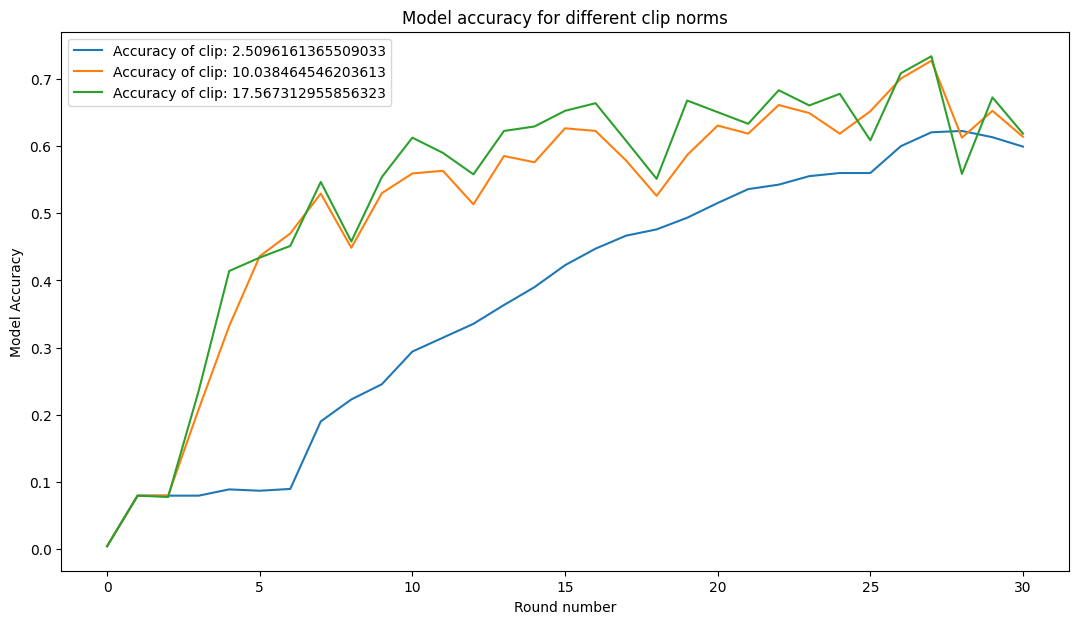

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 7))


for clip, clip_result in exp_3_results.items():
    parameters, hist = clip_result
    clip_round_accuracies = [accuracy for _, accuracy in hist.metrics_centralized["accuracy"]]
    plt.plot(clip_round_accuracies, label=f"Accuracy of clip: {clip}")


plt.xlabel("Round number")
plt.ylabel("Model Accuracy")
plt.title("Model accuracy for different clip norms")
plt.legend()
plt.show()







**Written Answer:**

From the plots above we can see that the model that was trained using clipping norm $\mu$ * 0.25 ($\approx$ 2.5) takes the longest to converge. This is caused by the fact that the model updates are being clipped frequently resulting in smaller changes/ improvements in the model. On the other hand, when we look at the models with the clipping norm $\mu$ ($\approx$ 10) and $\mu$ * 1.75 ($\approx$ 17.6) we can see a similar trend and convergence ($\mu$ * 1.75 being slightly better) which can be explained by the fact that if the mean unclipped L2 norms is $\mu$ then the model with the clipping norm $\mu$ * 1.75 will clip above the mean value which happens less frequently. Additionally, this larger bound allows larger updates which cause the higher magnitude of changes/fluctuations than the $\mu$ model but also . Additionally, the $\mu$ * 1.75 model achieves the best accuracy, which could be a cause of the less bounded updates. Interestingly all three models converge to a similar/close accuracy which might be caused by the fact the $\mu$ * 0.25 applies smaller but more "stable" resulting in less fluctuations over time.

---

---

**Question 4 (Part II ✅ | Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

This question extends the one above to investigate the effect that the `clip_norm` has upon the norm of the federated model update. The federated model update is defined as the difference between the model at the start of the round and the model post-aggregation.

1. Using the results from the above question, plot the following:

   - The L2 norm of the federated model deltas across rounds for the three bounds above. How does L2 norm of the federated model delta compare to `clip_norm` (draw a horizontal line for all three bounds)? Is the behaviour as you expected, and why/why not?
   - The accuracy on the federated test set of models trained using the three norms above against the cumulative L2 norm accumulated across rounds as the axis. Consider the accuracy of the initial parameter test (round 0) to map to an L2 norm of 0. By cumulative L2, we mean a running sum where you keep adding the new norm value to the sum and then add the sum to a per-round list. Such a sum can easily be computed from a list using a `accumulate()` call.

2. How do the L2 norms of the federated model deltas compare against the change in accuracy between rounds? Is the relationship predictable and/or linear? Consider all the `clip_norm` values you have tried in your response and provide potential explanations for why/why not the relationship between accuracy and cumulative L2 changes between bounds.


---

**Question 4 Answer:**

Part 1:

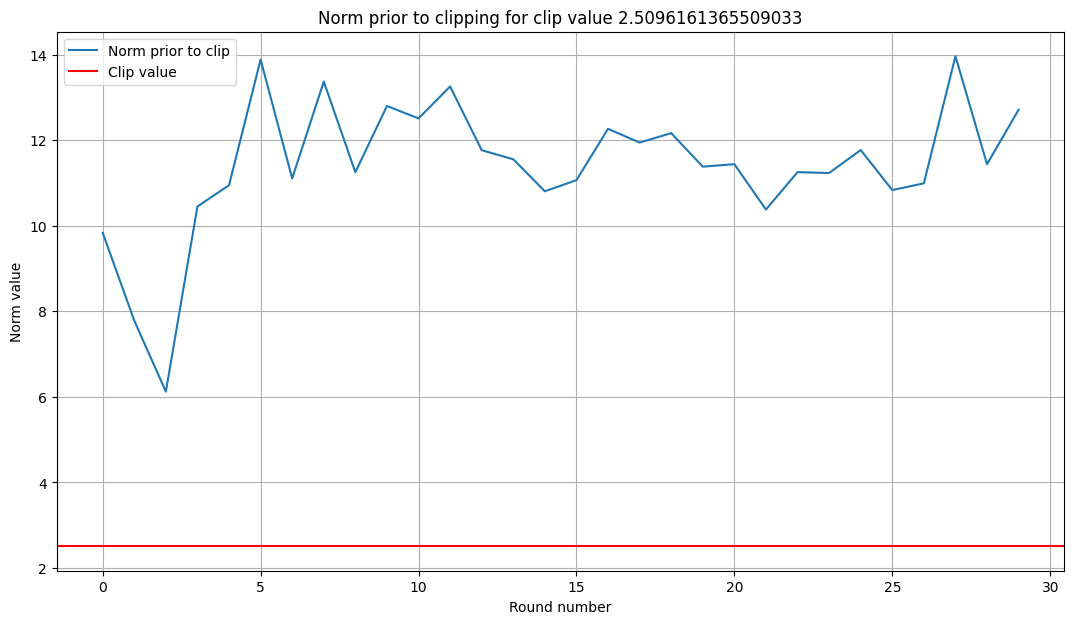

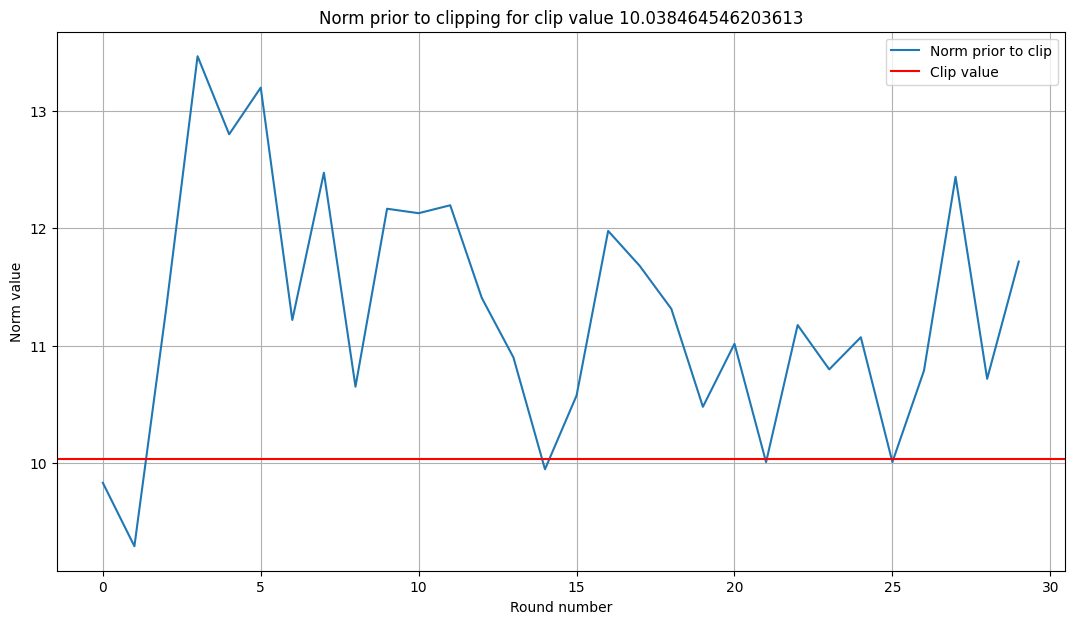

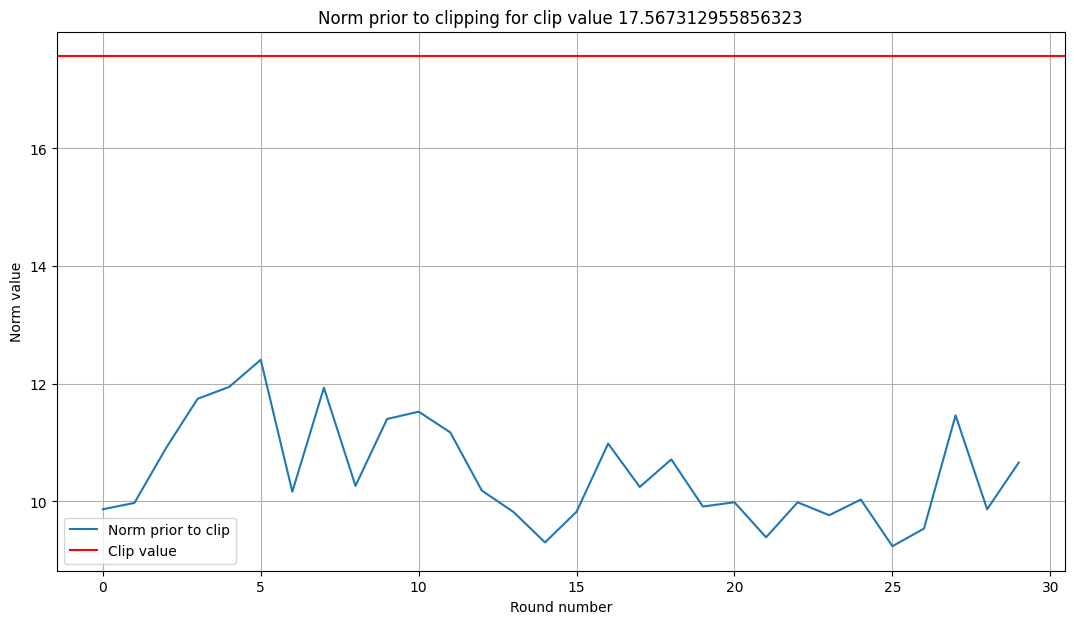

In [72]:
import itertools
for clip_val, clip_result in exp_3_results.items():
    parameters, hist = clip_result

    
    prior_clip_norms = [ np.mean([ value for _, value in norm_prior_clip["all"]]) for round, norm_prior_clip in hist.metrics_distributed_fit["norm_prior_clip"]]

    plt.figure(figsize=(13, 7))
    plt.plot(prior_clip_norms, label="Norm prior to clip")
    plt.axhline(y=clip_val, color='r', linestyle='-', label="Clip value")
    plt.xlabel("Round number")
    plt.ylabel("Norm value")
    plt.title(f"Norm prior to clipping for clip value {clip_val}")
    plt.legend()
    plt.grid(True)
    plt.show()


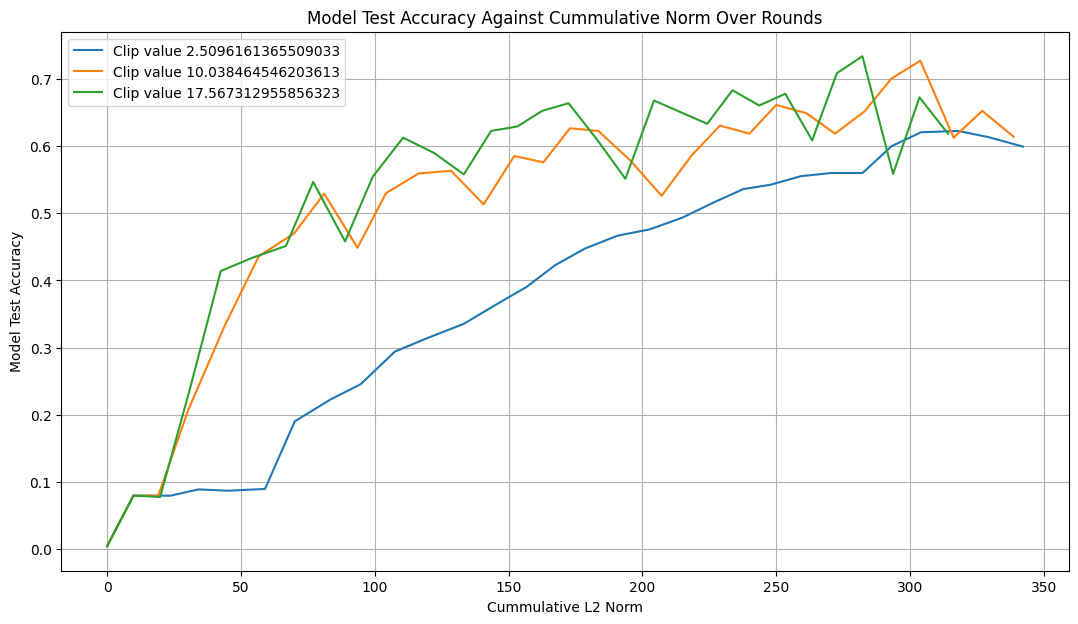

In [119]:
plt.figure(figsize=(13, 7))
for clip_val, clip_result in exp_3_results.items():
    parameters, hist = clip_result

    prior_clip_norms = [ np.mean([ value for _, value in norm_prior_clip["all"]]) for round, norm_prior_clip in hist.metrics_distributed_fit["norm_prior_clip"]]
    prior_clip_norms.insert(0,0)
    cumulative_norm = list(itertools.accumulate(prior_clip_norms))
    accuracies = [accuracy for _, accuracy in hist.metrics_centralized["accuracy"]]

    plt.plot(cumulative_norm,accuracies, label=f"Clip value {clip_val}")

plt.xlabel("Cummulative L2 Norm")
plt.ylabel("Model Test Accuracy")
plt.title(f"Model Test Accuracy Against Cummulative Norm Over Rounds")
plt.legend()
plt.grid(True)
plt.show()

**Written Answer:**
Regarding the models with with the clip norm $\mu$ * 0.25 and $\mu$ * 1.75 the results were somewhat expected. The L2 norm of model updates for the model with the clip norm of $\mu$ * 0.25 are all above the set clip norm line resulting in all of them being clipped meanwhile the opposite happens to the model with the clip norm of $\mu$ * 1.75 where the updates reside below the set clip norm hence not being clipped. However, the model with the clip norm of $\mu$ present a rather surprising result to what I was expecting. Contrary to expected most updates of the $\mu$ model are above the set clip norm line resulting in them being clipped rather than around half of them being clipped. This could be explained by the fact that we set the clip norm based on the mean of only a single round of training. Since magnitudes of updates change across rounds using a single round to determine the clip norm might not be ideal approach.


Part 2:

**Written Answer:**

As we can see on the graph there is no predictable relationship between the L2 norm of the federated model deltas and the change in acc



---

## 3.2 Adaptive Norm Bound DP


Having investigated the impact of gradient clipping with a fixed norm on performance, you may wonder if your chosen norm will stay appropriate for the entire training.

To avoid perfectly tuning a fixed `clip_norm` an [adaptive version of DPFedAvg](https://arxiv.org/abs/1905.03871) was proposed in paper \[3], which attempts to automatically scale the bound on the L2 norm of model updates based on a quantile of L2 norms provided by clients in a given round. As computing such a value would be computationally expensive and require clients to send private values, the paper proposes an algorithm meant to approximate the quantile.

Specifically, it adjusts the `clip_norm` parameter as:

>     self.clip_norm *= math.exp(-self.clip_norm_lr

            * (noised_clients_with_clipped_norm_fraction - self.clip_norm_target_quantile)
        )

where the new clip norm depends on a learning rate, the fraction of clients used in training who have clipped their norms (with added noise), and the target quantile. In the code below, the clients who have clipped their norm are reported via a set bit in the config, and thus `noised_clients_with_clipped_norm_fraction` is replaced with `noised_norm_bit_set_fraction`. By knowing approximately how many clients fall below a given norm, we can iteratively improve the `clip_norm` until the percentage of clients with norms smaller than the bound is reached.

The new implementation is hard to use and balance for short experiments such as ours as it includes an initial phase where the norm grows exponentially in its attempts to converge to the actual quantile. Given that we do not want any further interference making the behaviour of DP harder to predict, this would prove inconvenient when trying to deduce the impact of noise. As such, we shall only track the behaviour of the adaptive norm and use the predictable `DPFedAvgFixed` when experimenting with obtaining a given level of $\epsilon$ privacy.


In [77]:
"""DP-FedAvg [Andrew et al., 2019] with adaptive clipping.
Paper: https://arxiv.org/pdf/1905.03871.pdf
"""

# Original implementation by Vasundhara Agarwal


class DPFedAvgAdaptive(DPFedAvgFixed):
    """Server-side adaptive clipping for DP-FedAvg."""

    # pylint: disable=too-many-arguments,too-many-instance-attributes
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: (
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                tuple[float, dict[str, Scalar]] | None,
            ]
            | None
        ) = None,
        on_fit_config_fn: Callable[[int], dict[str, Scalar]] | None = None,
        on_evaluate_config_fn: Callable[[int], dict[str, Scalar]] | None = None,
        accept_failures: bool = False,
        initial_parameters: Parameters | None = None,
        fit_metrics_aggregation_fn: MetricsAggregationFn | None = None,
        evaluate_metrics_aggregation_fn: MetricsAggregationFn | None = None,
        server_learning_rate: float = 1.0,
        server_momentum: float = 0.0,
        num_clients_per_round: int,
        init_clip_norm: float = 0.1,
        noise_multiplier: float = 1,
        server_side_noising: bool = True,
        clip_norm_lr: float = 0.2,
        clip_norm_target_quantile: float = 0.5,
        clip_count_stddev: float | None = None,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
            server_learning_rate=server_learning_rate,
            server_momentum=server_momentum,
            num_clients_per_round=num_clients_per_round,
            clip_norm=init_clip_norm,
            noise_multiplier=noise_multiplier,
            server_side_noising=server_side_noising,
        )
        self.clip_norm_lr = clip_norm_lr
        self.clip_norm_target_quantile = clip_norm_target_quantile
        self.clip_count_stddev = clip_count_stddev

        # Decides the level of noise added to the fraction of clients which have clipped
        # their norms
        if self.clip_count_stddev is None:
            self.clip_count_stddev = 0
            if noise_multiplier > 0:
                self.clip_count_stddev = self.num_clients_per_round / 20.0

        if noise_multiplier:
            self.noise_multiplier = (
                self.noise_multiplier ** (-2) - (2 * self.clip_count_stddev) ** (-2)
            ) ** (-0.5)

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        additional_config = {"dpfedavg_adaptive_clip_enabled": True}

        client_instructions = super().configure_fit(
            server_round, parameters, client_manager
        )

        for _, fit_ins in client_instructions:
            fit_ins.config.update(additional_config)

        return client_instructions

    def _update_clip_norm(self, results: list[tuple[ClientProxy, FitRes]]) -> None:
        """Update the clipping norm based on the fraction of clients which clipped."""
        # Calculating number of clients which set the norm indicator bit
        norm_bit_set_count = 0
        for client_proxy, fit_res in results:
            if "dpfedavg_norm_bit" not in fit_res.metrics:
                raise DPClientNormBitError(
                    f"Indicator bit not returned by client with id {client_proxy.cid}."
                )

            if fit_res.metrics["dpfedavg_norm_bit"]:
                norm_bit_set_count += 1
        # Noising the count
        noised_norm_bit_set_count = float(
            np.random.normal(norm_bit_set_count, self.clip_count_stddev)
        )

        noised_norm_bit_set_fraction = noised_norm_bit_set_count / len(results)
        # Geometric update
        self.clip_norm *= math.exp(
            -self.clip_norm_lr
            * (noised_norm_bit_set_fraction - self.clip_norm_target_quantile)
        )

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[tuple[ClientProxy, FitRes] | BaseException],
    ) -> tuple[Parameters | None, dict[str, Scalar]]:
        """Aggregate the results of the training round."""
        if not self.accept_failures and failures:
            return None, {}
        new_global_model, metrics = super().aggregate_fit(
            server_round, results, failures
        )
        self._update_clip_norm(results)
        metrics["adaptive_clip_norm"] = self.clip_norm
        return new_global_model, metrics

In [78]:
# New function to run the adaptive norm experiments with sensible defaults

dp_client_generator = get_dp_client_generator(
    network_generator_cnn,
    data_dir,
    federated_partition,
    lambda x: client_samples_dataframe.cid[x],
)


adaptive_default_parameters: dict = {
    "train_config": get_default_train_config(),
    "test_config": get_default_test_config(),
    "num_total_clients": num_total_clients,
    "num_clients_per_round": 4,
    "num_evaluate_clients": 0,
    "num_evaluate": 0,
    "accept_failures": False,
    "min_fit_clients": 2,
    "min_available_clients": 2,
    "initial_parameters": ndarrays_to_parameters(seed_model_cnn_params),
    "client_generator": dp_client_generator,
    "seed": Seeds.DEFAULT,
    "num_rounds": 30,
    "strategy": DPFedAvgAdaptive,
    "fed_eval": True,
    "server_side_noising": True,
    "clip_count_stddev": None,
}


def run_dp_adaptive_fl(
    noise_multiplier: float = 0,
    init_clip_norm: float = 2,
    clip_norm_lr: float = 0.2,
    clip_norm_target_quantile: float = 0.5,
    default_parameters: dict = adaptive_default_parameters,
    **kwargs: dict[str, Any],
) -> Any:
    """Execute a DP-FedAvg simulation with adaptive clipping."""
    parameters: dict = {**default_parameters, **kwargs}

    def on_fit_config_fn(cid: int) -> dict[str, Scalar]:
        return parameters["train_config"]

    def on_evaluate_config_fn(cid: int) -> dict[str, Scalar]:
        return parameters["test_config"]

    fraction_fit: float = (
        float(parameters["num_clients_per_round"]) / parameters["num_total_clients"]
    )
    fraction_evaluate: float = (
        float(parameters["num_evaluate_clients"]) / parameters["num_total_clients"]
    )

    strategy = parameters["strategy"](
        num_clients_per_round=parameters["num_clients_per_round"],
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=parameters["min_fit_clients"],
        min_available_clients=parameters["min_available_clients"],
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        initial_parameters=parameters["initial_parameters"],
        accept_failures=parameters["accept_failures"],
        evaluate_fn=(
            federated_evaluation_function if parameters["fed_eval"] is True else None
        ),
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        init_clip_norm=init_clip_norm,
        clip_norm_lr=clip_norm_lr,
        clip_norm_target_quantile=clip_norm_target_quantile,
        noise_multiplier=noise_multiplier,
        server_side_noising=parameters["server_side_noising"],
        clip_count_stddev=parameters["clip_count_stddev"],
    )
    client_manager = CustomClientManager(criterion=None, seed=parameters["seed"])
    server = Server(
        client_manager=client_manager,
        strategy=strategy,
    )
    return start_seeded_simulation(
        client_fn=lambda cid: parameters["client_generator"](cid).to_client(),
        num_clients=parameters["num_total_clients"],
        server=server,
        config=ServerConfig(num_rounds=parameters["num_rounds"]),
        strategy=strategy,
        seed=parameters["seed"],
        name=f"adaptive_target_{clip_norm_target_quantile}_init_clip_norm_{init_clip_norm}_lr_{clip_norm_lr}_noise_{noise_multiplier}",
    )

In [79]:
parameters_for_every_round, hist_adaptive_quantile_0_5 = run_dp_adaptive_fl(
    clip_norm_target_quantile=0.5, noise_multiplier=0
)

WARNING flwr 2025-02-15 21:58:49,789 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-02-15 21:58:49,792 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flwr 2025-02-15 21:58:49,815 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-15 21:58:49,817 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-15 21:58:49,822 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:01<00:00, 43.92it/s]
INFO flwr 2025-02-15 21:58:51,052 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576580047607, {'accuracy': 0.004}
INFO:flw

Having gone through this slight detour to understand how we could obtain an adaptive bound which leaves the privacy budget mostly undisturbed without experimentation, we shall return to DP's primary goal, matching a given theoretical bound on privacy. However, Part III and MPhil students will now get to play around and observe the behaviour of this adaptive norm algorithm.


**Question 5 (Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

You will now examine the accuracy of adaptive norm clipping compared to the previously fixed norm clipping.

1. Using values of `clip_norm_target_quantile`$\in \{0.125,\, 0.5, \,0.875\}$ (you should already have results for the default value from the cells above. If you have lost it, look into the `histories` folder). Run `DPFedAvgAdaptive` experiments with the same parameters as the above example using a `noise_multiplier=0`.
2. Plot the per-round accuracy on the federated test set of models trained using the three quantile targets above. Which quantile target converges the fastest and to the highest final accuracy, and why do you think that is? Are the results as conclusive as the fixed bound ones? **Hint**: consider the exponential nature of the bound adaptation.
3. Do an ordered pairwise comparison between the plots of per-round accuracy of the previous three `clip_norm` results for the fixed norm experiments against the adaptive norm experiments, i.e., plot `clip_norm=mean*0.25` against `clip_norm_target_quantile=0.125`, `clip_norm=mean` against `clip_norm_target_quantile=0.5`, and `clip_norm=mean*1.75` against `clip_norm_target_quantile=0.875`. How does each of the pairs compare? Where are the differences most pronounced, and why do you think that is?


**Question 5 Answer:**

Part 1:


In [80]:
clip_norm_target_quantiles = [0.125, 0.5, 0.875]

adaptive_results = {}
for target_quantile in clip_norm_target_quantiles:
    target_quantile_parameters, target_quantile_hist = run_dp_adaptive_fl(clip_norm_target_quantile=target_quantile, noise_multiplier=0)
    adaptive_results[target_quantile] = (target_quantile_parameters, target_quantile_hist)


WARNING flwr 2025-02-15 22:08:12,399 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-02-15 22:08:12,411 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flwr 2025-02-15 22:08:12,439 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-15 22:08:12,442 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-15 22:08:12,474 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 52.82it/s]
INFO flwr 2025-02-15 22:08:13,444 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576580047607, {'accuracy': 0.004}
INFO:flw

Part 2:

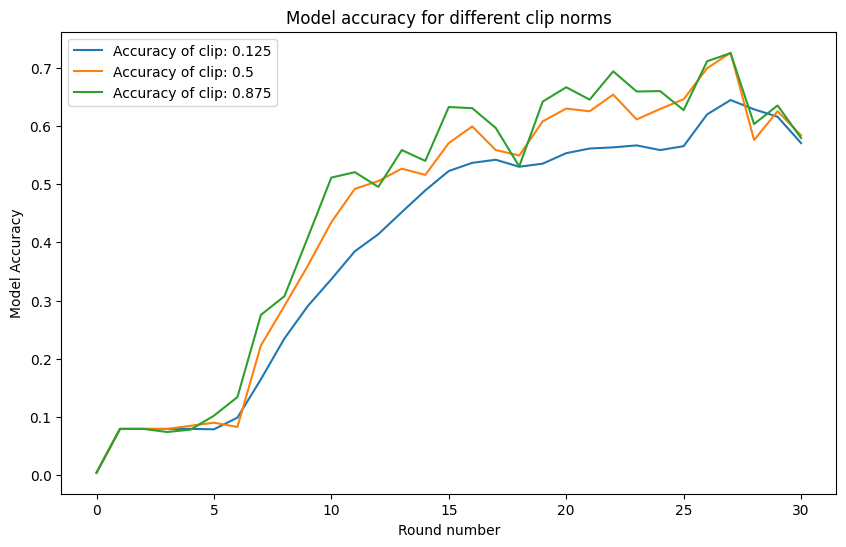

In [122]:
plt.figure(figsize=(10, 6))


for target_quantile, target_quantile_result in adaptive_results.items():
    parameters, hist = target_quantile_result
    target_quantile_accuracies = [accuracy for _, accuracy in hist.metrics_centralized["accuracy"]]
    plt.plot(target_quantile_accuracies, label=f"Accuracy of clip: {target_quantile}")


plt.xlabel("Round number")
plt.ylabel("Model Accuracy")
plt.title("Model accuracy for different clip norms")
plt.legend()
plt.show()

**Written Answer:**

From the plot we can see that models with quantile 0.5 and 0.875 converge at a really similar rate while the model with the quantile 0.125 converges slightly slower. 

Part 3:

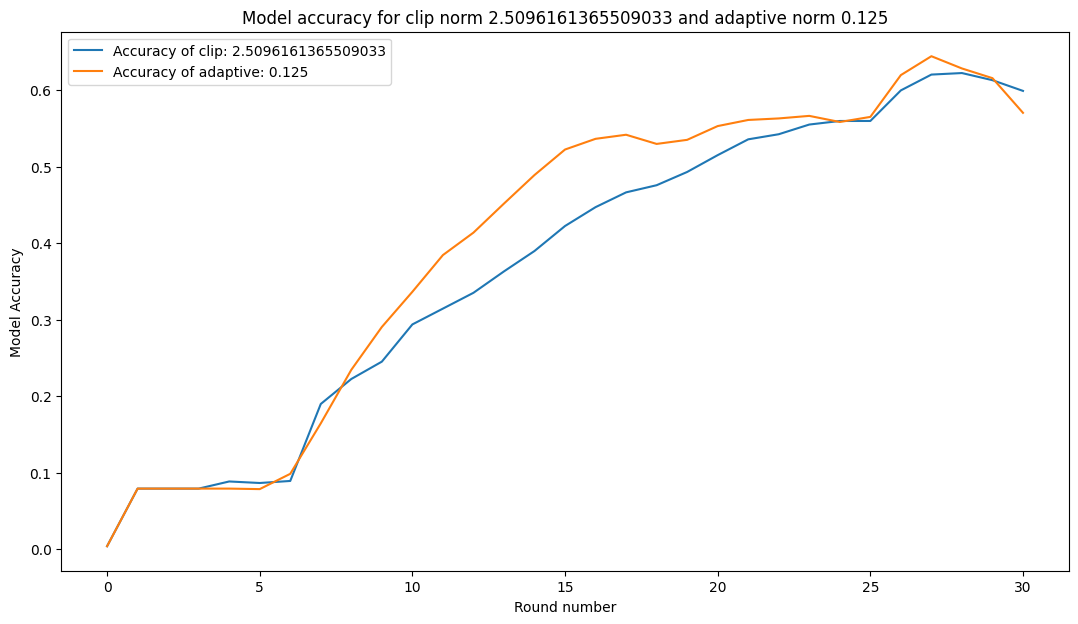

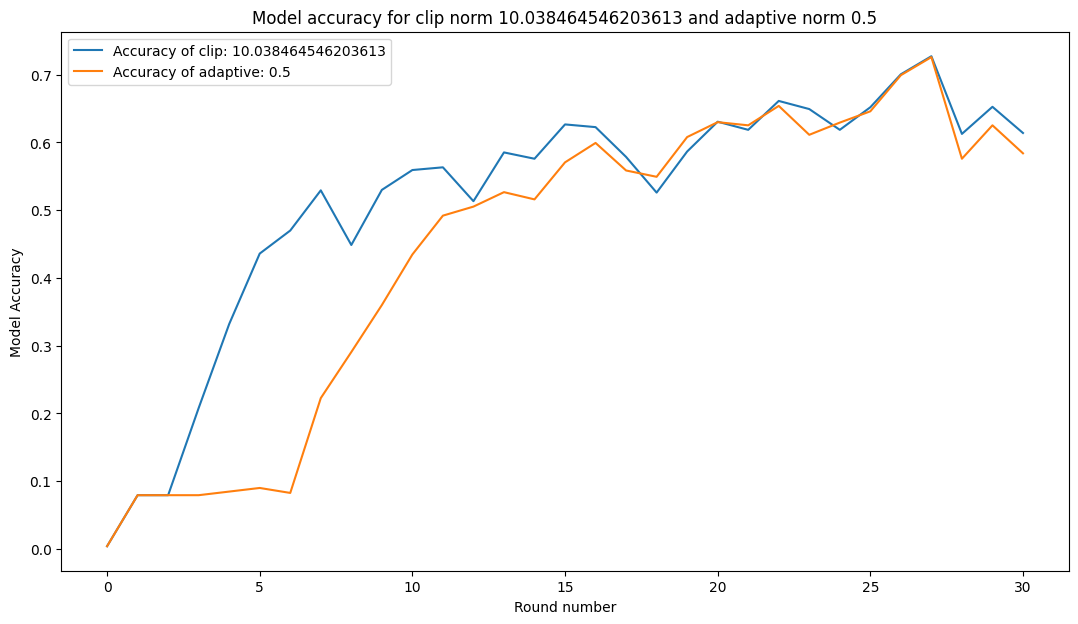

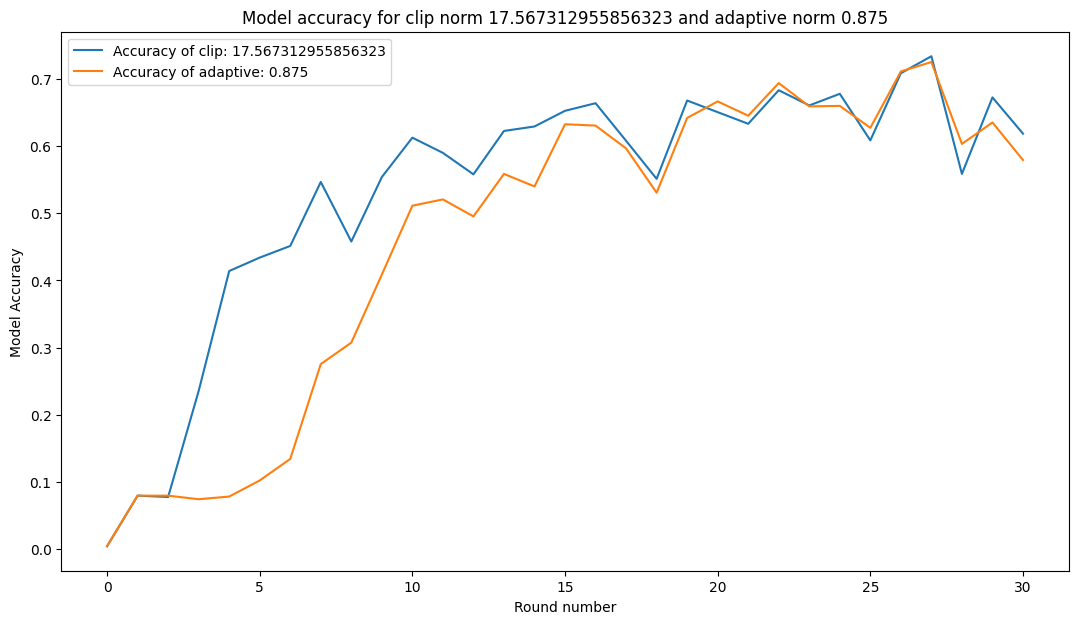

In [89]:
experiment_pairs = list(zip(exp_3_results.keys(), adaptive_results.keys()))

for clip_norm_val, adaptive_norm_val in experiment_pairs:
    clip_result = exp_3_results[clip_norm_val]
    adaptive_result = adaptive_results[adaptive_norm_val]

    clip_parameters, clip_hist = clip_result
    adaptive_parameters, adaptive_hist = adaptive_result

    clip_accuracy = [accuracy for _, accuracy in clip_hist.metrics_centralized["accuracy"]]
    adaptive_accuracy = [accuracy for _, accuracy in adaptive_hist.metrics_centralized["accuracy"]]

    plt.figure(figsize=(13, 7))
    plt.plot(clip_accuracy, label=f"Accuracy of clip: {clip_norm_val}")
    plt.plot(adaptive_accuracy, label=f"Accuracy of adaptive: {adaptive_norm_val}")
    plt.xlabel("Round number")
    plt.ylabel("Model Accuracy")
    plt.title(f"Model accuracy for clip norm {clip_norm_val} and adaptive norm {adaptive_norm_val}")
    plt.legend()
    plt.show()
    

**Written Answer:**




---

**Question 6 (Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

This is an extension to the previous question, which tries to expand upon how the adaptive norm applied to client gradients/updates affects the L2 norm of the federated model delta.

1. Using the previous results for `clip_norm_target_quantile`$\in \{0.125,\, 0.5, \,0.875\}$, plot the L2 norm of the federated model delta for each target quantile. Which of the target quantiles causes the most considerable oscillations in the federated L2 norm, and why do you think that is?
2. Do a similar ordered pairwise comparison between the federated L2 norm results of the target quantile experiments against those of the fixed bound experiments as in the previous question. Where is the gap between the adaptive and fixed method the largest?
3. Plot the accuracy of experiments with the adaptive bounds against the cumulative L2 norm.


---
**Question 6 Answer:**

Part 1:

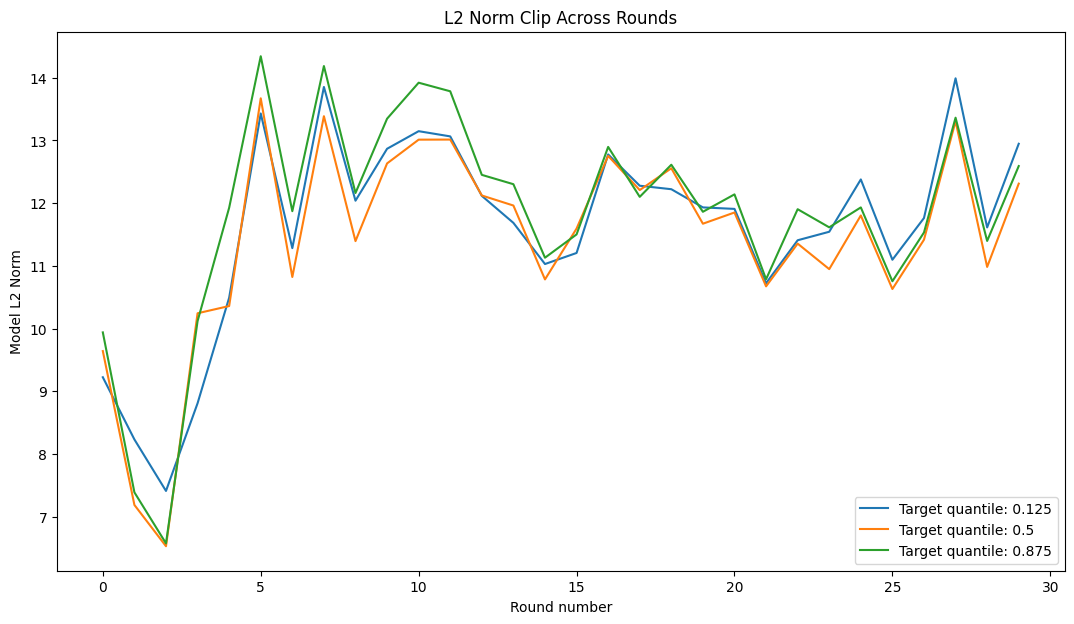

In [123]:
plt.figure(figsize=(13, 7))
for target_quantile, target_quantile_result in adaptive_results.items():
    parameters, hist = target_quantile_result

    prior_clip_norms = [ np.mean([ value for _, value in norm_prior_clip["all"]]) for round, norm_prior_clip in hist.metrics_distributed_fit["norm_prior_clip"]]
    plt.plot(prior_clip_norms, label=f"Target quantile: {target_quantile}")


plt.xlabel("Round number")
plt.ylabel("Model L2 Norm")
plt.title("L2 Norm Clip Across Rounds")
plt.legend()
plt.show()

**Written Answer:**

Out of the three models, the most considerable oscillations appears in the model with the target quantile of 0.875 which is probably caused by the fact that clipping bound is so high that not many updates are clipped. Unlike with the models with lower quantile where clipping happens less frequently smoothing out L2 norm, the model with the largest quantile does not have this smoothing/capping effect that frequently resulting in larger fluctuations in the L2 norm.

Part 2:

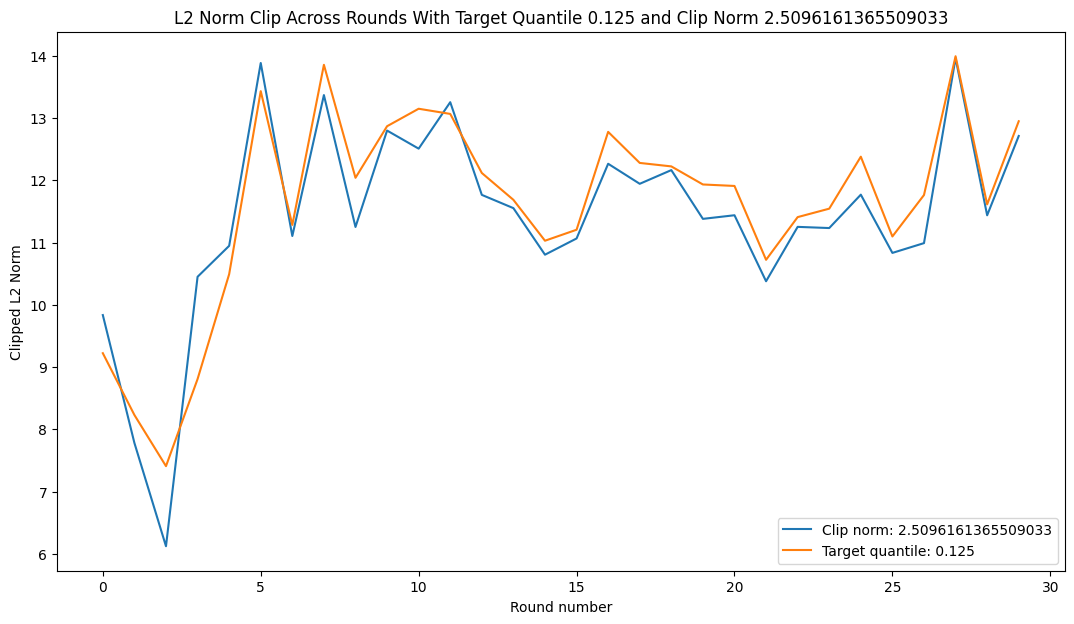

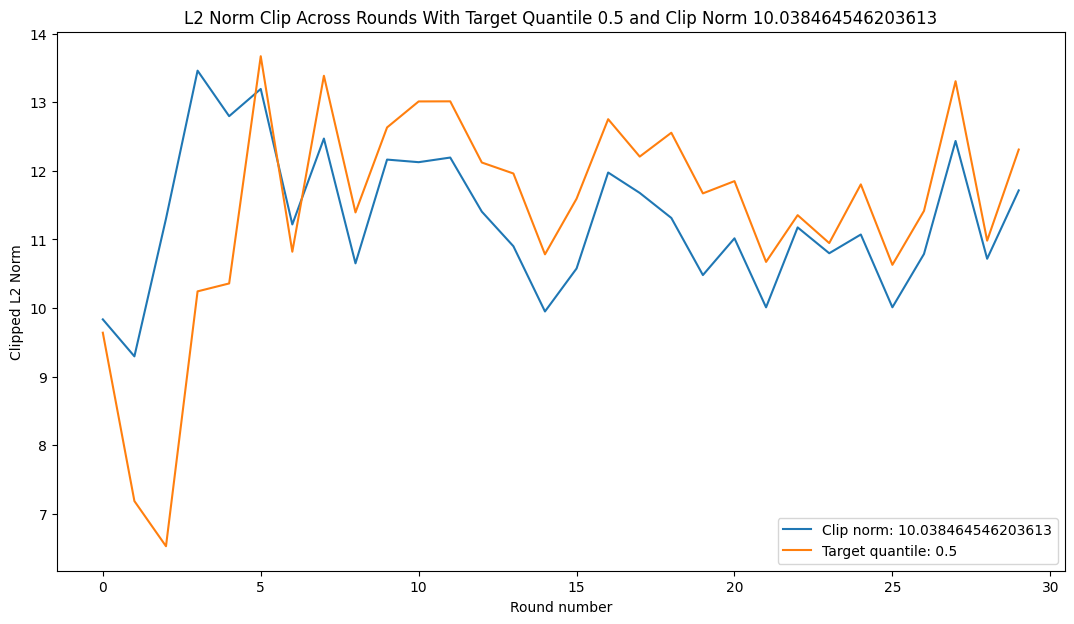

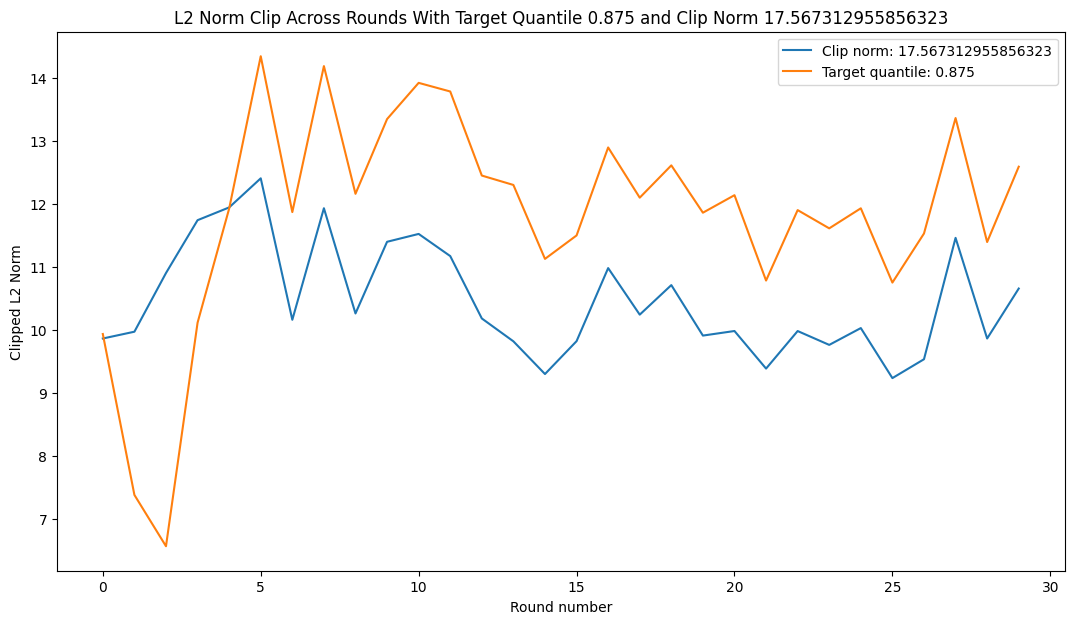

In [94]:
experiment_pairs = list(zip(exp_3_results.keys(), adaptive_results.keys()))

for clip_norm_val, adaptive_norm_val in experiment_pairs:
    clip_result = exp_3_results[clip_norm_val]
    adaptive_result = adaptive_results[adaptive_norm_val]

    clip_parameters, clip_hist = clip_result
    adaptive_parameters, adaptive_hist = adaptive_result

    clip_norms = [ np.mean([ value for _, value in norm_prior_clip["all"]]) for round, norm_prior_clip in clip_hist.metrics_distributed_fit["norm_prior_clip"]]
    target_quantile_norms = [ np.mean([ value for _, value in norm_prior_clip["all"]]) for round, norm_prior_clip in adaptive_hist.metrics_distributed_fit["norm_prior_clip"]]
    
    plt.figure(figsize=(13, 7))
    plt.plot(clip_norms, label=f"Clip norm: {clip_norm_val}")
    plt.plot(target_quantile_norms, label=f"Target quantile: {adaptive_norm_val}")

    plt.xlabel("Round number")
    plt.ylabel("Clipped L2 Norm")
    plt.title(f"L2 Norm Clip Across Rounds With Target Quantile {adaptive_norm_val} and Clip Norm {clip_norm_val}")
    plt.legend()
    plt.show()


**Written Answer:**

The gap between the adaptive and fixed method for the models appears to be at the beginning of the training/ in earlier rounds. This can be the result of the adaptive method starting with lower clipping bounds and gradually increasing them as the training progresses. 

Part 3:

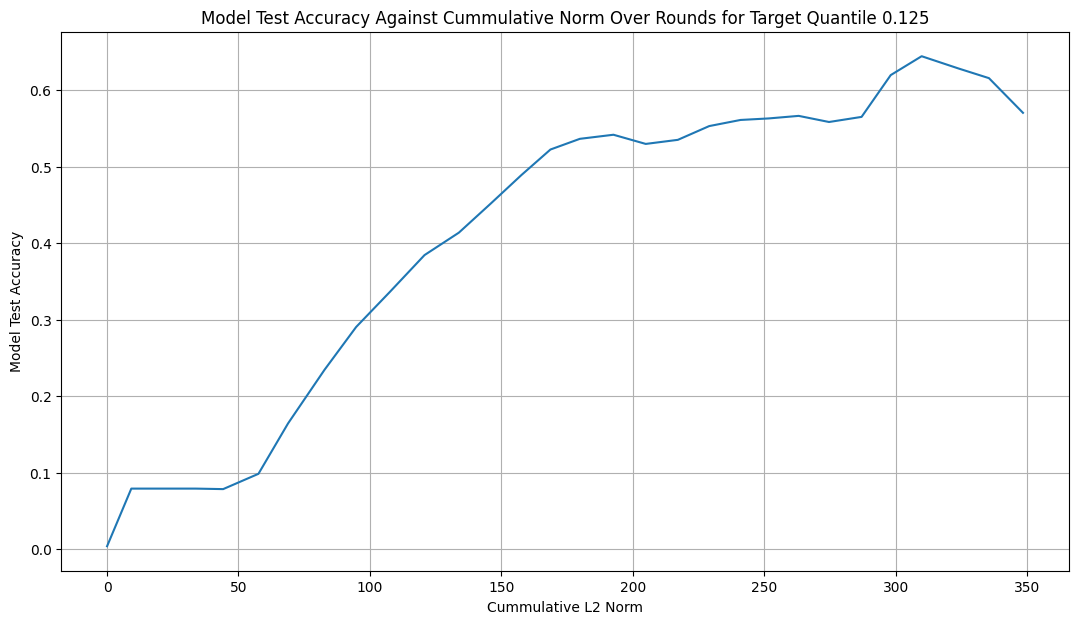

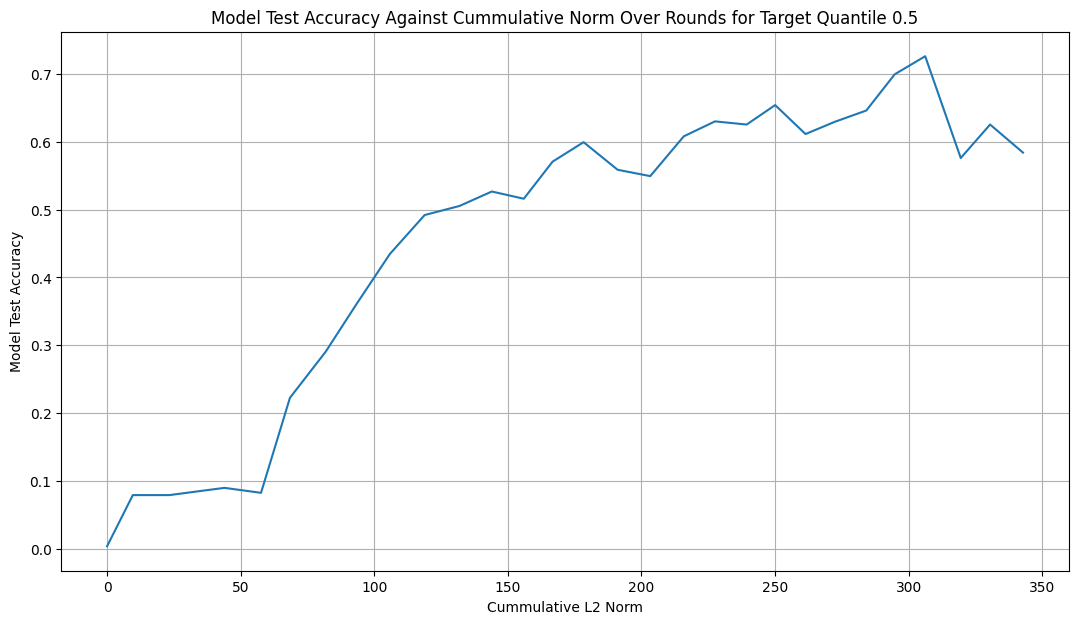

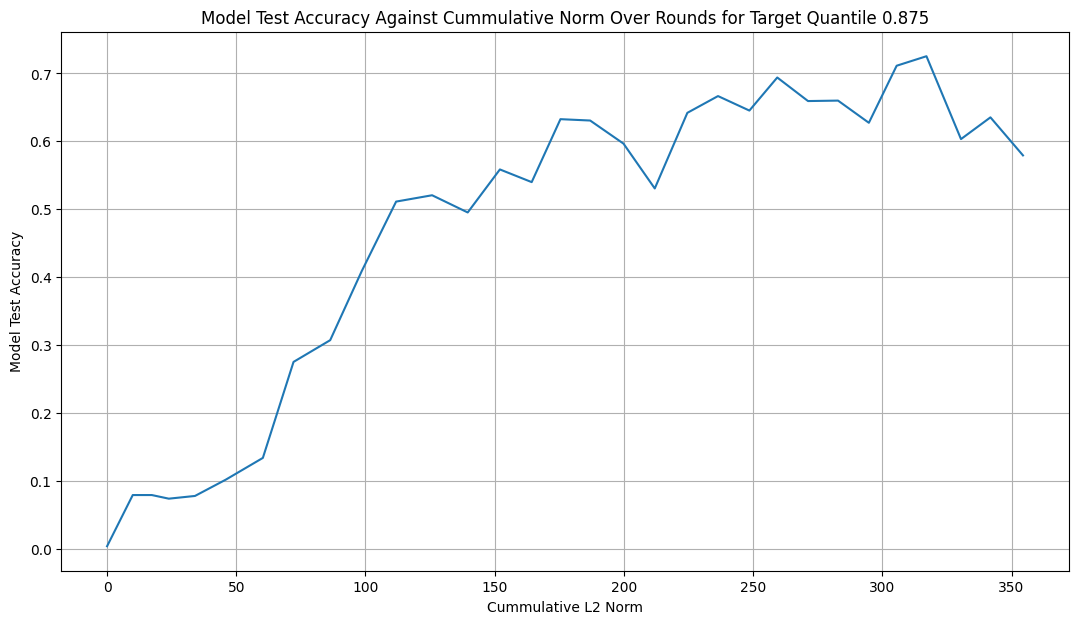

In [95]:
for target_quantile, target_quantile_result in adaptive_results.items():
    parameters, hist = target_quantile_result

    prior_clip_norms = [ np.mean([ value for _, value in norm_prior_clip["all"]]) for round, norm_prior_clip in hist.metrics_distributed_fit["norm_prior_clip"]]
    prior_clip_norms.insert(0,0)
    cumulative_norm = list(itertools.accumulate(prior_clip_norms))
    accuracies = [accuracy for _, accuracy in hist.metrics_centralized["accuracy"]]

    plt.figure(figsize=(13, 7))
    plt.plot(cumulative_norm,accuracies)
    plt.xlabel("Cummulative L2 Norm")
    plt.ylabel("Model Test Accuracy")
    plt.title(f"Model Test Accuracy Against Cummulative Norm Over Rounds for Target Quantile {target_quantile}")
    plt.grid(True)
    plt.show()

# 4 Epsilon-delta Privacy


We are now ready to understand the full extent of the DPFedAvg fixed algorithm and the relation between its privacy guarantees and the accuracy of the final model.

Before this, we should establish what a particular set of DP parameters implies for the level of privacy theoretically. The function below shall allow us to do just that while assuming a fixed number of rounds and clients per round. It adapts a function provided by TensorFlow privacy for DP-SGD, as we have established that DP-FedAvg and DP-SGD are equivalent when considering a mere reframing of samples as clients; it should provide sufficient accuracy for our purposes.


In [96]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import (
    compute_dp_sgd_privacy,
)
from contextlib import redirect_stdout
from io import StringIO


class NullIO(StringIO):
    """Custom IO interface to cut-out annoying messages."""

    def write(self, txt: str) -> None:
        """Implement custom empty write function."""
        # This function intentionally does nothing


def compute_fl_privacy(
    num_rounds: int = 25,
    noise_multiplier: float = 1.0,
    num_total_clients: int = num_total_clients,
    num_fit_clients: int = 4,
) -> float:
    """Compute the privacy bound `epsilon`."""
    with redirect_stdout(NullIO()):
        vals = compute_dp_sgd_privacy(
            n=num_total_clients,
            batch_size=num_fit_clients,
            noise_multiplier=noise_multiplier,
            epochs=num_rounds,
            delta=num_total_clients ** (-1),
        )
    return vals[0]

In [97]:
log(INFO, compute_fl_privacy(noise_multiplier=0.05))
log(INFO, compute_fl_privacy(noise_multiplier=1.0))

INFO flwr 2025-02-15 23:40:35,969 | 3928211183.py:1 | 4363302.374442753
INFO:flwr:4363302.374442753


INFO flwr 2025-02-15 23:40:35,988 | 3928211183.py:2 | 0.7541536967384
INFO:flwr:0.7541536967384


**Question 7 (Part II ✅ | Part III/MPhil ✅):**

(While this is a largely conceptual question, it does require you to provide a small amount of **code** and several **plots**. Answers to the purely conceptual components should contain **no more than 5 sentences**.)

Using the function mentioned above, study the impact of different parameters on the privacy guarantees of DP-FedAvg as follows:

1. Draw a scatter plot with the epsilon value on the y-axis. While keeping all the other parameters constant to the above values, vary the noise multiplier from 0.05 to 2 using an increment of 0.05. Use the noise multiplier as the x-axis.

2. Draw a scatter plot with the epsilon value on the y-axis. While keeping all the other parameters constant to the above values, vary `num_rounds` between $2^0$ and $2^{15}$ increasing using all the powers of two in the interval. Use the `num_rounds` as the x-axis.

3. Draw a scatter plot with the epsilon value on the y-axis. While keeping all the other parameters constant to the above values, vary `num_fit_cliets` from $2^0$ to $2^{10}$ increasing using all the powers of two in the interval. Use the `num_fit_cliets` as x-axis.

4. Describe the trade-offs you see and how they relate to FL privacy. <!-- Then, given the lecture by Peter Kairouz, what do you think the implications of these trade-offs are upon the practicality of Differential Privacy in FL? --> Then, what do you think are the implications of these trade-offs upon the practicality of differential privacy in FL?


Armed with this theoretical understanding of the privacy budget, we can explore the performance implications of Differential Privacy upon DPFedAvgFixed. Note once more that the experiments we are running are small scale, as such you may find particularly high sensitivity to the `noise_multiplier` to be present.


---

**Question 7 Answer:**

Part 1:

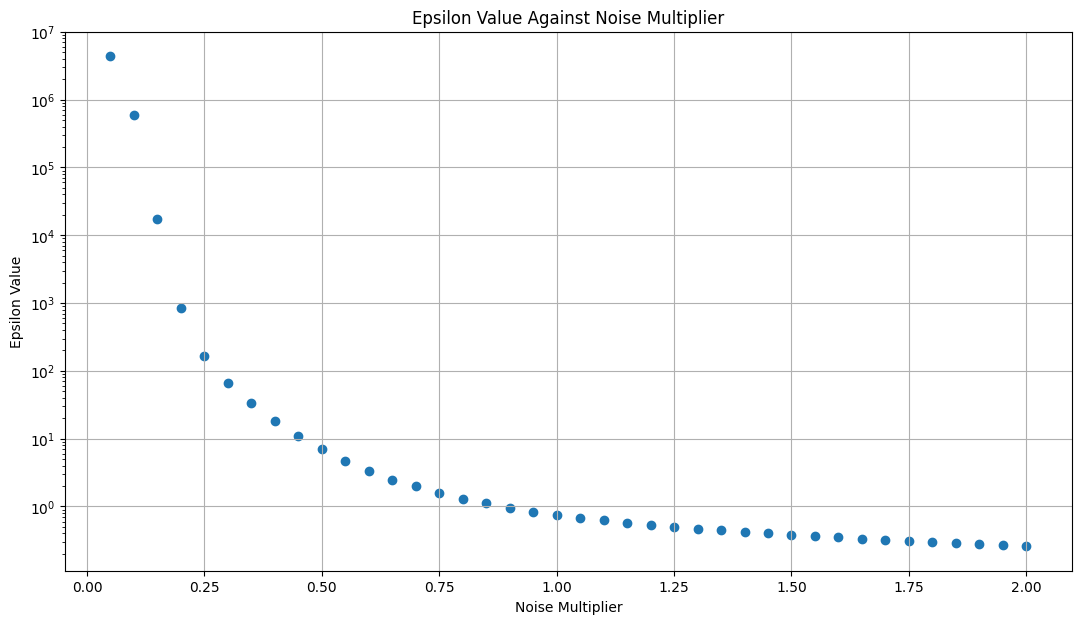

In [107]:
noise_multipliers = np.arange(0.05, 2.05, 0.05)
epsilon_noise_values = [compute_fl_privacy(noise_multiplier=noise_multiplier) for noise_multiplier in noise_multipliers]

plt.figure(figsize=(13, 7))
plt.scatter(noise_multipliers, epsilon_noise_values)
plt.xlabel("Noise Multiplier")
plt.ylabel("Epsilon Value")
plt.yscale('log')
plt.title("Epsilon Value Against Noise Multiplier")
plt.grid(True)
plt.show()

Part 2:

[    1     2     4     8    16    32    64   128   256   512  1024  2048
  4096  8192 16384 32768]


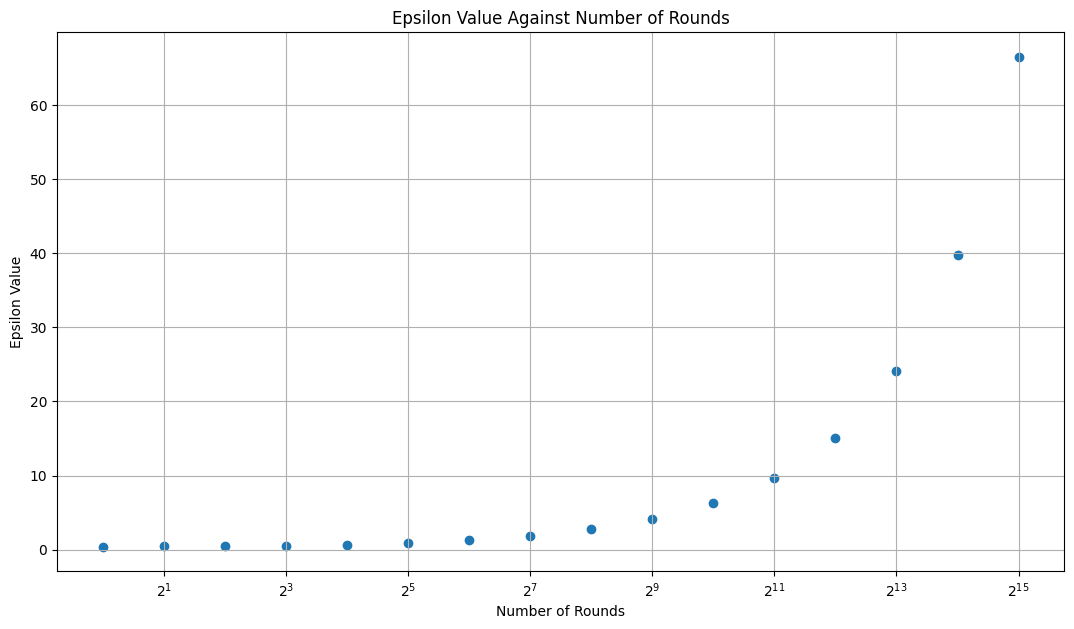

In [112]:
num_rounds_values = 2** np.arange(16)
epsilon_round_values = [compute_fl_privacy(num_rounds=num_rounds) for num_rounds in num_rounds_values]

plt.figure(figsize=(13, 7))
plt.scatter(num_rounds_values, epsilon_round_values)
plt.xlabel("Number of Rounds")
plt.ylabel("Epsilon Value")
plt.xscale('log', base=2)
plt.title("Epsilon Value Against Number of Rounds")
plt.grid(True)
plt.show()

Part 3:

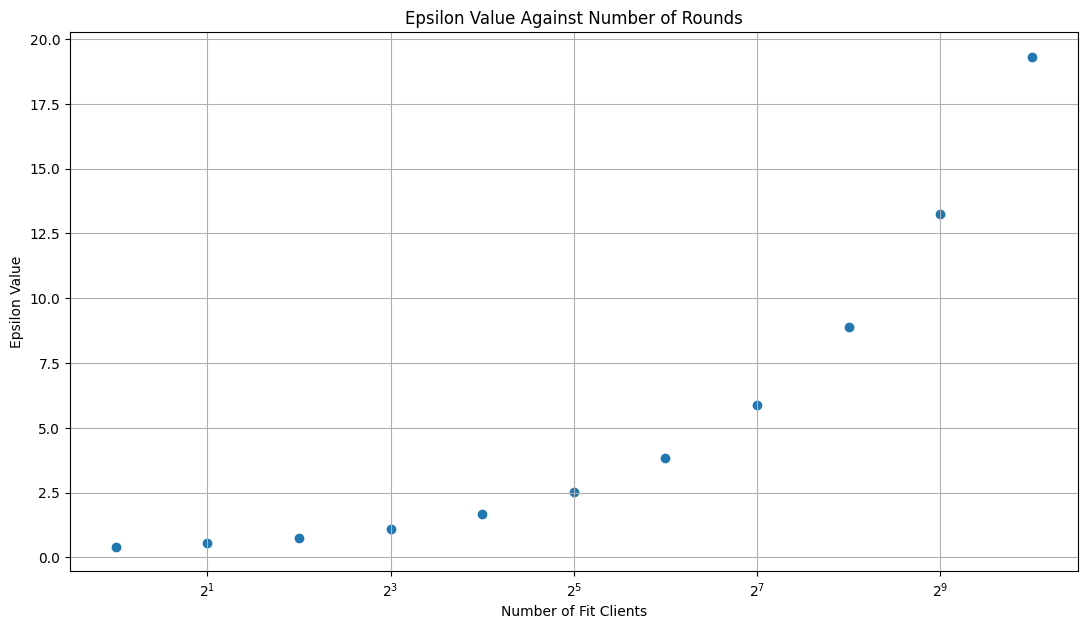

In [113]:
num_fit_client_values = 2** np.arange(11)
epsilon_client_values = [compute_fl_privacy(num_fit_clients=num_fit_clients) for num_fit_clients in num_fit_client_values]

plt.figure(figsize=(13, 7))
plt.scatter(num_fit_client_values, epsilon_client_values)
plt.xlabel("Number of Fit Clients")
plt.ylabel("Epsilon Value")
plt.xscale('log', base=2)
plt.title("Epsilon Value Against Number of Rounds")
plt.grid(True)
plt.show()

Part 4:

The first plot shows that as the noise multiplier increases the epsilon value decreases with it resulting in an increased level of privacy. However, it is important to consider the effects increased noise has on the data and therefore on the accuracy of the model as too much noise might decrease the model's accuracy. On the second  and third plot we cans see that as the number of rounds/fit clients increases the epsilon value increases with it as both increase the  cumulative information that can be exploited such data transfer with rounds and particular clients participating in them. With these trade-offs the practicality of DP in FL might be more limited/ difficult to achieve as it is scaled, since to combat the privacy leakage of the increased rounds and fit clients we have to increase our noise multiplier which might result in a less accurate model.

---

**Question 8 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Using the results of the previous experiment, observe the impact that a given noise multiplier has on both performance and privacy when using a **fixed** norm bound.

1. Set a `noise_multiplier`$\in \{0.1\}$ while keeping all other parameters constant. Then run the FL simulation using the `DPFedAvgFixed` strategy from above.

2. Plot accuracy and compare the convergence curves against the results you have for the previous experiment with a multiplier of $0.05$ (`hist_clip_bound_4_noise_0_05`). _NOTE: it was done just after defining the aforementioned strategy._

3. Use the `compute_fl_privacy` function to compute the epsilon value of two noise levels mentioned above. How does the epsilon of a given noise level relate to the accuracy achieved by that model? Does the relationship between the two fit your expectations from the question above?


---

**Question 8 Answer:**

Part 1:

In [114]:
parameters_0_1, hist_0_1 = run_dp_fixed_fl(4, noise_multiplier=0.1)

WARNING flwr 2025-02-16 01:03:31,164 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-02-16 01:03:31,166 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flwr 2025-02-16 01:03:31,184 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-16 01:03:31,186 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-16 01:03:31,191 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
100%|██████████| 47/47 [00:01<00:00, 41.02it/s]
INFO flwr 2025-02-16 01:03:32,483 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576580047607, {'accuracy': 0.004}
INFO:flw

Part 2:

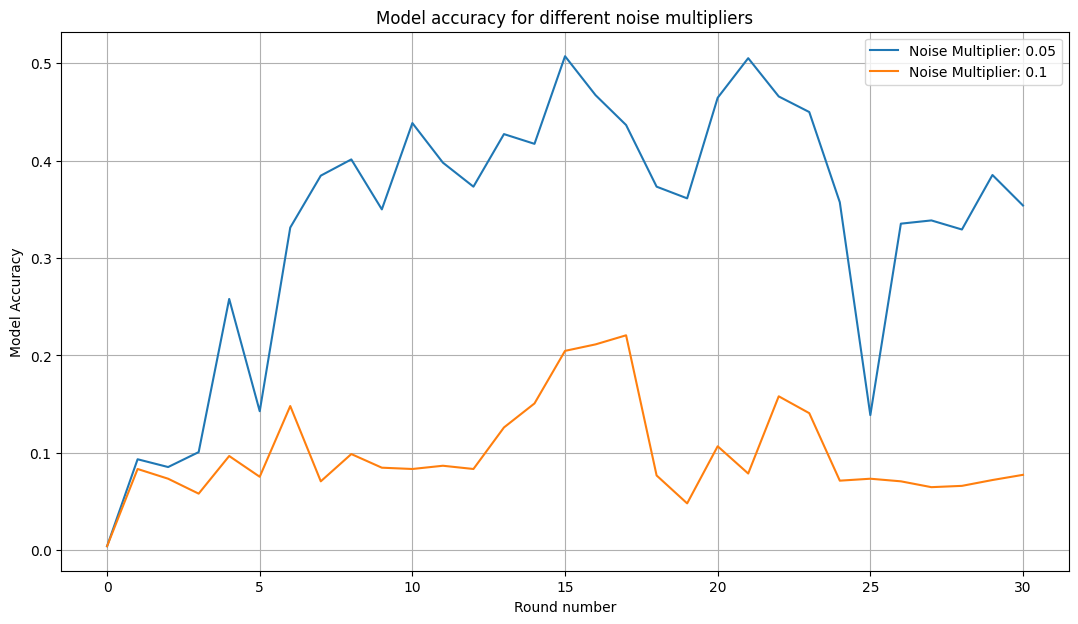

In [115]:
accuracies_0_05 = [accuracy for _, accuracy in hist_clip_bound_4_noise_0_05.metrics_centralized["accuracy"]]
accuracies_0_1 = [accuracy for _, accuracy in hist_0_1.metrics_centralized["accuracy"]]

plt.figure(figsize=(13, 7))
plt.plot(accuracies_0_05, label="Noise Multiplier: 0.05")
plt.plot(accuracies_0_1, label="Noise Multiplier: 0.1")
plt.xlabel("Round number")
plt.ylabel("Model Accuracy")
plt.title("Model accuracy for different noise multipliers")
plt.legend()
plt.grid(True)
plt.show()



Part 3:

In [116]:
epsilon_0_05 = compute_fl_privacy(noise_multiplier=0.05)
epsilon_0_1 = compute_fl_privacy(noise_multiplier=0.1)
print(f"Epsilon value for noise multiplier 0.05: {epsilon_0_05}")
print(f"Epsilon value for noise multiplier 0.1: {epsilon_0_1}")

Epsilon value for noise multiplier 0.05: 4363302.374442753
Epsilon value for noise multiplier 0.1: 585233.9431437703


**Written Answer:**

The plot clearly present the signifiant impact of noise multiplier on model accuracy. We can see that even a small increase in noise multiplier from 0.05 to 0.1 results in a significant decrease in model accuracy presenting their inverse relationship which was expected based on the results of the previous experiment. On the other hand we can also observe the small change in the noise multiplier does not only effect of the model accuracy greatly but the epsilon value as well hence increasing the privacy level. This shows the sensitivity that a FL system has to the noise multiplier and the trade-off between privacy and accuracy.


# End of Part I

Continue to part 2.


(c) 2024 Alexandru-Andrei Iacob, Lorenzo Sani
